In [1]:
import sqlite3
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import os
import requests
import time
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import time
from scipy.stats import ttest_ind


In [7]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 3.9 MB/s eta 0:00:39
   ---------------------------------------- 1.6/150.0 MB 4.7 MB/s eta 0:00:32
    --------------------------------------- 2.9/150.0 MB 5.2 MB/s eta 0:00:29
   - -------------------------------------- 4.5/150.0 MB 5.9 MB/s eta 0:00:25
   - -------------------------------------- 6.3/150.0 MB 6.5 MB/s eta 0:00:23
   -- ------------------------------------- 7.9/150.0 MB 6.6 MB/s eta 0:00:22
   -- ------------------------------------- 11.0/150.0 MB 7.8 MB/s eta 0:00:18
   --- ------------------------------------ 14.9/150.0 MB 9.2 MB/s eta 0:00:15
   ----- ---------------------------------- 18.9/150.0 MB 10.3 MB/s eta 0:00:13
   ----- ---------------------------------- 21.8/150.0 MB 10.7 MB/s eta 0:00:13
   ------ --------------------------------- 25.7/150.0 MB 11.4 MB/s eta 0:00:11
   -------- ------------------------------- 30.4/150.0 MB 12.5 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
conn = sqlite3.connect("Database/news_data.db")

In [8]:
df = pd.read_sql_query("""
                        SELECT 
                            ticker
                        FROM Stocks
                        """, conn)

tickers = df["ticker"].values.tolist()

In [9]:
len(tickers)

23

In [10]:
def get_complete_df(tickers, future_time_offset):
    """
    Fetch and process data for the given tickers with a customizable future time offset.

    Parameters:
    - tickers: List of stock tickers.
    - future_time_offset: String representing the time offset for future price (e.g., '+1 hour', '+2 hours', '+1 day').

    Returns:
    - A DataFrame containing the processed data.
    """
    dfs_list = []
    for ticker in tickers:
        query = f"""
            SELECT 
                a.ticker,
                a.url,
                a.title,
                a.summary,
                a.source_domain,
                a.closest_time_before_published,
                datetime(a.closest_time_before_published, '{future_time_offset}') AS 'future_time',
                CASE
                    WHEN TIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '{future_time_offset}') > '19:50:00'
                    THEN DATE(REPLACE(a.closest_time_before_published, '+00:00', ''), '+1 day') || ' 13:30:00'
                    ELSE DATETIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '{future_time_offset}')
                END AS adjusted_future_time,
                s.open AS open_price,
                f.close AS future_price,
                a.time_published
            FROM {ticker}_NewsArticles AS a
            LEFT JOIN {ticker}PriceHistory AS s 
                ON a.closest_time_before_published = s.date
            LEFT JOIN {ticker}PriceHistory AS f 
                ON REPLACE(f.date, '+00:00', '') = adjusted_future_time
        """

        # Execute the query and fetch the data
        df = pd.read_sql_query(query, conn)
        print(f"Fetched {len(df)} rows for ticker: {ticker}")
        dfs_list.append(df)

    # Combine all dataframes into one
    complete_df = pd.DataFrame()
    for df in dfs_list:
        if not df.empty:
            df = df.drop_duplicates(subset=["summary", "title"])
            complete_df = pd.concat([complete_df, df], ignore_index=True)

    # Drop rows with missing values
    complete_df = complete_df.dropna()

    print(f"Final DataFrame columns: {complete_df.columns}")
    print(f"Total rows in complete DataFrame: {len(complete_df)}")

    return complete_df

In [ ]:
dfs_list = []
for ticker in tickers:
    query = f"""
            SELECT 
                a.ticker,
                a.url,
                a.title,
                a.summary,
                a.source_domain,
                a.closest_time_before_published,
                datetime(a.closest_time_before_published, '1+ hour') AS 'future_time',
                CASE
                    WHEN TIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '1+ hour') > '19:50:00'
                    THEN DATE(REPLACE(a.closest_time_before_published, '+00:00', ''), '+1 day') || ' 13:30:00'
                    ELSE DATETIME(REPLACE(a.closest_time_before_published, '+00:00', ''), '1+ hour')
                END AS adjusted_future_time,
                s.open AS open_price,
                f.close AS future_price,
                a.time_published
            FROM {ticker}_NewsArticles AS a
            LEFT JOIN {ticker}PriceHistory AS s 
                ON a.closest_time_before_published = s.date
            LEFT JOIN {ticker}PriceHistory AS f 
                ON REPLACE(f.date, '+00:00', '') = adjusted_future_time
        """

    # Execute the query and fetch the data
    df = pd.read_sql_query(query, conn)
    print(f"Fetched {len(df)} rows for ticker: {ticker}")
    dfs_list.append(df)


final_df = pd.DataFrame()

for df in dfs_list:
    if not df.empty:
        ticker = df["ticker"][0]
        grouped = df.groupby('source_domain').size().reset_index(name=f'{ticker}_frequency')
        final_df = pd.concat([final_df, grouped], ignore_index=True)


"final_df = final_df.groupby('source_domain').sum().reset_index()\nprint(final_df.sort_values(by='frequency', ascending=False))"

In [34]:
final_df["sum_frequency"] = final_df.filter(like='_frequency').sum(axis=1)

In [42]:
grouped_final_df = final_df.groupby('source_domain').sum(numeric_only=True).reset_index()

In [45]:
len(grouped_final_df)

52

In [5]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 10000)

In [62]:

grouped_final_df[grouped_final_df["sum_frequency"] > 500].sort_values(by='sum_frequency', ascending=False)

,source_domain,AAPL_frequency,MSFT_frequency,NVDA_frequency,BAC_frequency,GS_frequency,PLD_frequency,O_frequency,SPG_frequency,XOM_frequency,CVX_frequency,SLB_frequency,AMZN_frequency,WMT_frequency,TGT_frequency,KO_frequency,PG_frequency,PEP_frequency,JNJ_frequency,PFE_frequency,NFLX_frequency,DIS_frequency,sum_frequency
23,www.benzinga.com,697.0,406.0,321.0,296.0,503.0,85.0,78.0,134.0,552.0,545.0,531.0,332.0,465.0,405.0,259.0,284.0,412.0,436.0,443.0,384.0,488.0,8056.0
51,www.zacks.com,345.0,263.0,257.0,138.0,116.0,217.0,267.0,397.0,1064.0,1137.0,871.0,340.0,127.0,544.0,305.0,340.0,238.0,336.0,244.0,234.0,145.0,7925.0
33,www.fool.com,360.0,260.0,426.0,417.0,196.0,199.0,855.0,98.0,600.0,855.0,24.0,618.0,274.0,280.0,516.0,302.0,399.0,208.0,285.0,242.0,59.0,7473.0
39,www.investors.com,98.0,36.0,77.0,18.0,22.0,5.0,2.0,18.0,52.0,130.0,158.0,60.0,16.0,42.0,20.0,45.0,12.0,25.0,9.0,26.0,3.0,874.0
27,www.cnbc.com,11.0,55.0,88.0,121.0,65.0,2.0,5.0,36.0,84.0,6.0,34.0,11.0,61.0,9.0,23.0,51.0,41.0,37.0,50.0,33.0,21.0,844.0
37,www.globenewswire.com,0.0,30.0,10.0,39.0,52.0,6.0,0.0,10.0,96.0,10.0,84.0,1.0,24.0,3.0,44.0,40.0,34.0,117.0,140.0,36.0,19.0,795.0
34,www.forbes.com,10.0,53.0,40.0,18.0,20.0,12.0,3.0,32.0,72.0,24.0,14.0,2.0,47.0,11.0,44.0,31.0,36.0,38.0,31.0,176.0,52.0,766.0
45,www.prnewswire.com,2.0,29.0,11.0,16.0,15.0,20.0,35.0,20.0,40.0,20.0,34.0,0.0,26.0,15.0,34.0,61.0,69.0,53.0,59.0,15.0,75.0,649.0


In [64]:
grouped_final_df[grouped_final_df["sum_frequency"] > 500].sort_values(by='sum_frequency', ascending=False)[["source_domain","sum_frequency"]]

,source_domain,sum_frequency
23,www.benzinga.com,8056.0
51,www.zacks.com,7925.0
33,www.fool.com,7473.0
39,www.investors.com,874.0
27,www.cnbc.com,844.0
37,www.globenewswire.com,795.0
34,www.forbes.com,766.0
45,www.prnewswire.com,649.0


Model testing

In [11]:
complete_df = get_complete_df(tickers, '+1 hour')

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

In [29]:
complete_df.tail()

,ticker,url,title,summary,source_domain,closest_time_before_published,future_time,adjusted_future_time,open_price,future_price,time_published
26382,DIS,https://www.fool.com/earnings/call-transcripts...,Lindblad Expeditions ( LIND ) Q3 2024 Earnin...,LIND earnings call for the period ending Septe...,www.fool.com,2024-11-05 18:40:00+00:00,2024-11-05 19:40:00,2024-11-05 19:40:00,96.530,96.460,20241105T184517
26384,DIS,https://www.fool.com/earnings/call-transcripts...,fuboTV ( FUBO ) Q1 2024 Earnings Call Transc...,FUBO earnings call for the period ending March...,www.fool.com,2024-05-03 16:00:00+00:00,2024-05-03 17:00:00,2024-05-03 17:00:00,113.235,113.525,20240503T160016
26385,DIS,https://www.fool.com/investing/2024/10/21/the-...,The Semiconductor Stories of TSMC & ASML,"We also check in with Bob Stark, author of ""Th...",www.fool.com,2024-10-21 15:50:00+00:00,2024-10-21 16:50:00,2024-10-21 16:50:00,96.425,96.290,20241021T155200
26386,DIS,https://www.fool.com/earnings/call-transcripts...,Coca-Cola ( KO ) Q2 2024 Earnings Call Trans...,KO earnings call for the period ending June 30...,www.fool.com,2024-07-23 17:10:00+00:00,2024-07-23 18:10:00,2024-07-23 18:10:00,90.860,91.340,20240723T171520
26387,DIS,https://www.forbes.com/sites/sethmatlins/2024/...,The 2024 Forbes World's Most Influential CMOs ...,The 12th annual Forbes World's Most Influentia...,www.forbes.com,2024-06-19 19:50:00+00:00,2024-06-19 20:50:00,2024-06-20 13:30:00,101.490,100.850,20240620T103000


Tests

In [15]:
price_dfs = []
for ticker in tickers:
    query_price = f"""
            SELECT *
            FROM {ticker}PriceHistory 
        """

    # Execute the query and fetch the data
    price_df = pd.read_sql_query(query_price, conn)
    print(f"Fetched {len(price_df)} rows for ticker: {ticker}")
    price_dfs.append(price_df)

final_price_df = pd.DataFrame()

for df in price_dfs:
    if not df.empty:
        final_price_df = pd.concat([final_price_df, df], ignore_index=True)

print(len(final_price_df))

Fetched 20321 rows for ticker: AAPL
Fetched 20280 rows for ticker: MSFT
Fetched 20280 rows for ticker: NVDA
Fetched 20284 rows for ticker: JPM
Fetched 20284 rows for ticker: BAC
Fetched 20284 rows for ticker: GS
Fetched 20290 rows for ticker: PLD
Fetched 20290 rows for ticker: O
Fetched 20290 rows for ticker: SPG
Fetched 20301 rows for ticker: XOM
Fetched 20301 rows for ticker: CVX
Fetched 20301 rows for ticker: SLB
Fetched 20313 rows for ticker: AMZN
Fetched 20313 rows for ticker: WMT
Fetched 20313 rows for ticker: TGT
Fetched 20319 rows for ticker: KO
Fetched 20291 rows for ticker: PG
Fetched 20291 rows for ticker: PEP
Fetched 20280 rows for ticker: JNJ
Fetched 20280 rows for ticker: PFE
Fetched 20280 rows for ticker: NFLX
Fetched 20280 rows for ticker: DIS
Fetched 20280 rows for ticker: CMCSA
466746


In [16]:
final_price_df['date'] = pd.to_datetime(final_price_df['date'])
final_price_df.set_index('date', inplace=True)
final_price_df.sort_index(inplace=True)


In [12]:
news_release_df = complete_df[["closest_time_before_published","ticker"]]  # datetime of the news release
news_release_df['closest_time_before_published'] = pd.to_datetime(news_release_df['closest_time_before_published'])

C:\Users\andre\AppData\Local\Temp\ipykernel_14232\1510186416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_release_df['closest_time_before_published'] = pd.to_datetime(news_release_df['closest_time_before_published'])


In [14]:
news_release_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15891 entries, 0 to 26387
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   closest_time_before_published  15891 non-null  datetime64[ns, UTC]
 1   ticker                         15891 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 372.4+ KB


In [15]:
final_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 466746 entries, 2023-04-24 13:30:00+00:00 to 2025-04-29 15:10:00+00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      466746 non-null  int64  
 1   open    466746 non-null  float64
 2   high    466746 non-null  float64
 3   low     466746 non-null  float64
 4   close   466746 non-null  float64
 5   volume  466746 non-null  int64  
 6   ticker  466746 non-null  object 
 7   sector  466746 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 32.0+ MB


In [81]:
for i, row in news_release_df.iterrows():
    ticker = row['ticker']
    news_time = row['closest_time_before_published']

print(f"Ticker: {ticker}, News Time: {news_time}")

Ticker: DIS, News Time: 2024-06-19 19:50:00+00:00


In [84]:
print(final_price_df[(final_price_df['ticker'] == ticker)].loc[news_time]['close'])
one_hour = pd.Timedelta('1H')
try:
    print(final_price_df[(final_price_df['ticker'] == ticker)].loc[news_time + one_hour]['close'])
except KeyError:
    # If exact timestamp is missing, try the next available row after news_time + one_hour
    df_ticker = final_price_df[(final_price_df['ticker'] == ticker)]
    # Get all timestamps greater than news_time + one_hour
    next_times = df_ticker.index[df_ticker.index > news_time + one_hour]
    if len(next_times) > 0:
        next_time = next_times[0]
        print(f"Using next available time: {next_time}")
        print(df_ticker.loc[next_time]['close'])
    else:
        print("No available price after news_time + one_hour")

101.49
Using next available time: 2024-06-20 13:30:00+00:00
100.85


C:\Users\andre\AppData\Local\Temp\ipykernel_29948\1310418159.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  one_hour = pd.Timedelta('1H')


In [8]:
def compute_news_impact(news_df, price_df, timeframe='1h'):
    one_hour = pd.Timedelta(timeframe)
    news_moves = []

    for i, row in news_df.iterrows():
        ticker = row['ticker']
        news_time = row['closest_time_before_published']
        # Get price at release and one hour later
        try:
            price_at_release = price_df[(price_df['ticker'] == ticker)].loc[news_time]['close']
            try:
                price_1h_later = price_df[(price_df['ticker'] == ticker)].loc[news_time + one_hour]['close']
            except KeyError:
                # If exact timestamp is missing, try the next available row after news_time + one_hour
                df_ticker = price_df[(price_df['ticker'] == ticker)]
                # Get all timestamps greater than news_time + one_hour
                next_times = df_ticker.index[df_ticker.index > news_time + one_hour]
                if len(next_times) > 0:
                    next_time = next_times[0]
                    price_1h_later = df_ticker.loc[next_time]['close']
                else:
                    print(f"No available price after {news_time + one_hour} for ticker {ticker}")
                    continue
            
            ret = (price_1h_later - price_at_release) / price_at_release
            news_moves.append(ret)
            if len(news_moves) % 1000 == 0 or len(news_moves) == 1:
                print(f"len news_moves: {len(news_moves)}")
                print(f"Ticker: {ticker}, News Time: {news_time}")
        except KeyError:
            # Missing price data for exact timestamp
            continue

    return np.array(news_moves)


In [9]:
def compute_random_impact(price_df, news_count, timeframe='1h'):
    one_hour = pd.Timedelta(timeframe)
    random_moves = []

    tickers = price_df['ticker'].unique()

    for _ in range(news_count):
        ticker = np.random.choice(tickers)
        df = price_df[price_df['ticker'] == ticker]
        time = np.random.choice(df.index[:-6])  # exclude tail to ensure 1h data exists

        try:
            price_now = df.loc[time]['close']
            price_later = df.loc[time + one_hour]['close']
            ret = (price_later - price_now) / price_now
            random_moves.append(ret)
        except KeyError:
            continue

    return np.array(random_moves)


In [18]:
news_returns = compute_news_impact(news_release_df, final_price_df)
random_returns = compute_random_impact(final_price_df, len(news_returns))

len news_moves: 1
Ticker: AAPL, News Time: 2023-05-02 18:20:00+00:00
len news_moves: 1000
Ticker: AAPL, News Time: 2025-03-31 19:50:00+00:00
len news_moves: 2000
Ticker: MSFT, News Time: 2025-04-22 19:50:00+00:00
len news_moves: 3000
Ticker: NVDA, News Time: 2025-04-16 19:00:00+00:00
len news_moves: 4000
Ticker: BAC, News Time: 2025-04-03 19:50:00+00:00
len news_moves: 5000
Ticker: GS, News Time: 2025-04-01 14:40:00+00:00
len news_moves: 6000
Ticker: O, News Time: 2024-05-17 14:00:00+00:00
len news_moves: 7000
Ticker: XOM, News Time: 2024-10-29 19:50:00+00:00
len news_moves: 8000
Ticker: SLB, News Time: 2024-10-21 18:40:00+00:00
len news_moves: 9000
Ticker: AMZN, News Time: 2025-04-09 19:50:00+00:00
len news_moves: 10000
Ticker: WMT, News Time: 2025-04-18 17:00:00+00:00
len news_moves: 11000
Ticker: TGT, News Time: 2025-04-09 13:40:00+00:00
len news_moves: 12000
Ticker: PG, News Time: 2024-06-25 13:30:00+00:00
len news_moves: 13000
Ticker: PEP, News Time: 2024-10-01 19:50:00+00:00
len 

In [19]:
print(f"Mean return after news: {news_returns.mean():.4f}")
print(f"Mean return at random: {random_returns.mean():.4f}")

Mean return after news: -0.0001
Mean return at random: 0.0000


In [27]:
print("news_returns size:",len(news_returns), "random_returns size:",len(random_returns))

news_returns size: 15891 random_returns size: 13455


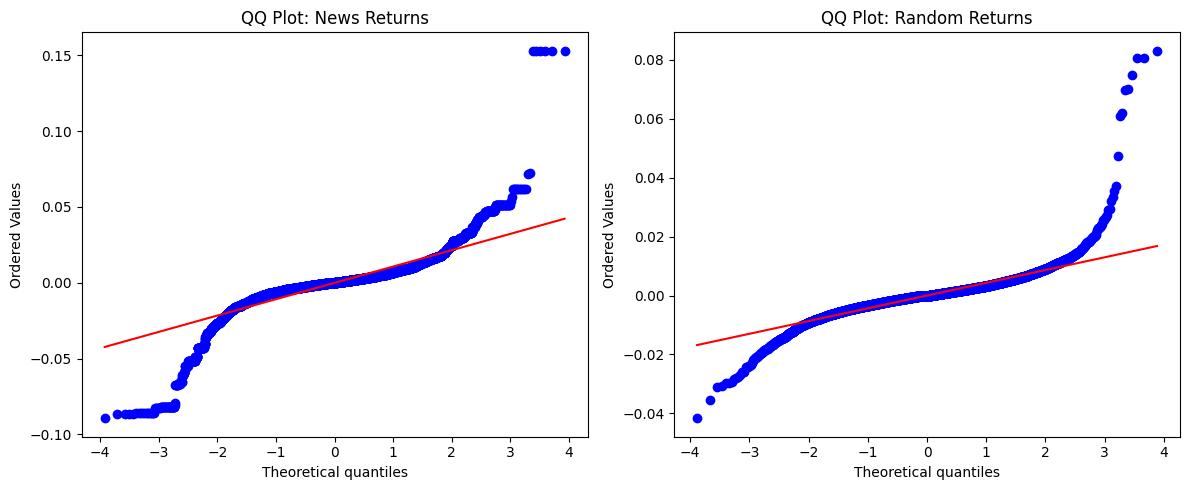

In [22]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# QQ plot for news_returns
plt.subplot(1, 2, 1)
stats.probplot(news_returns, dist="norm", plot=plt)
plt.title("QQ Plot: News Returns")

# QQ plot for random_returns
plt.subplot(1, 2, 2)
stats.probplot(random_returns, dist="norm", plot=plt)
plt.title("QQ Plot: Random Returns")

plt.tight_layout()
plt.show()

In [23]:
stat, p_val = mannwhitneyu(news_returns, random_returns, alternative='two-sided')

In [24]:
p_val

np.float64(0.005173233873677531)

Mean return after news: -0.0001
Mean return at random: -0.0000
T-test p-value: 0.5560


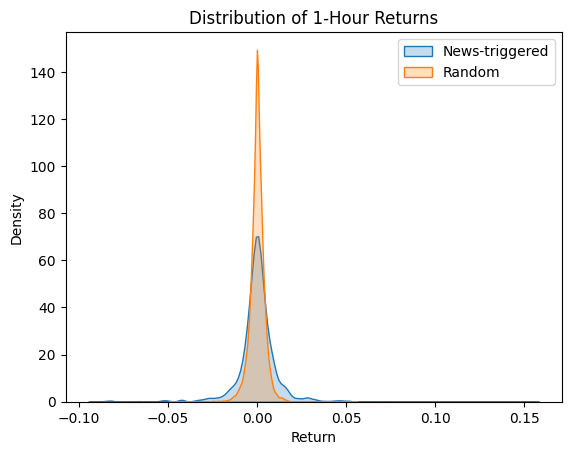

In [100]:


# Compare means
print(f"Mean return after news: {news_returns.mean():.4f}")
print(f"Mean return at random: {random_returns.mean():.4f}")

# T-test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(news_returns, random_returns)
print(f"T-test p-value: {p_val:.4f}")

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(news_returns, label='News-triggered', fill=True)
sns.kdeplot(random_returns, label='Random', fill=True)
plt.title("Distribution of 1-Hour Returns")
plt.xlabel("Return")
plt.legend()
plt.show()


In [34]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(news_returns, random_returns, alternative='two-sided')
print(f"Mann-Whitney U test: U={stat}, p-value={p}")

timeframes = ['10min', '30min', '1h', '5h', '1d']
t_tests = []
news_returns_list = []
random_returns_list = []
for timeframe in timeframes:
    print(f"Processing timeframe: {timeframe}")
    news_returns = compute_news_impact(news_release_df, final_price_df, timeframe)
    random_returns = compute_random_impact(final_price_df, len(news_returns), timeframe)
    
    print(f"Timeframe: {timeframe}")
    print(f"Mean return after news: {news_returns.mean():.4f}")
    print(f"Mean return at random: {random_returns.mean():.4f}")
    t_stat, p_val = ttest_ind(news_returns, random_returns, equal_var=False)
    print(f"T-test statistic: {t_stat:.4f}")
    print(f"T-test p-value: {p_val:.4f}")
    t_tests.append(p_val)
    news_returns_list.append(news_returns)
    random_returns_list.append(random_returns)


Mann-Whitney U test: U=108928519.5, p-value=0.005173233873677531
Processing timeframe: 10min
len news_moves: 1
Ticker: AAPL, News Time: 2023-05-02 18:20:00+00:00
len news_moves: 1000
Ticker: AAPL, News Time: 2025-03-31 19:50:00+00:00
len news_moves: 2000
Ticker: MSFT, News Time: 2025-04-22 19:50:00+00:00
len news_moves: 3000
Ticker: NVDA, News Time: 2025-04-16 19:00:00+00:00
len news_moves: 4000
Ticker: BAC, News Time: 2025-04-03 19:50:00+00:00
len news_moves: 5000
Ticker: GS, News Time: 2025-04-01 14:40:00+00:00
len news_moves: 6000
Ticker: O, News Time: 2024-05-17 14:00:00+00:00
len news_moves: 7000
Ticker: XOM, News Time: 2024-10-29 19:50:00+00:00
len news_moves: 8000
Ticker: SLB, News Time: 2024-10-21 18:40:00+00:00
len news_moves: 9000
Ticker: AMZN, News Time: 2025-04-09 19:50:00+00:00
len news_moves: 10000
Ticker: WMT, News Time: 2025-04-18 17:00:00+00:00
len news_moves: 11000
Ticker: TGT, News Time: 2025-04-09 13:40:00+00:00
len news_moves: 12000
Ticker: PG, News Time: 2024-06-2

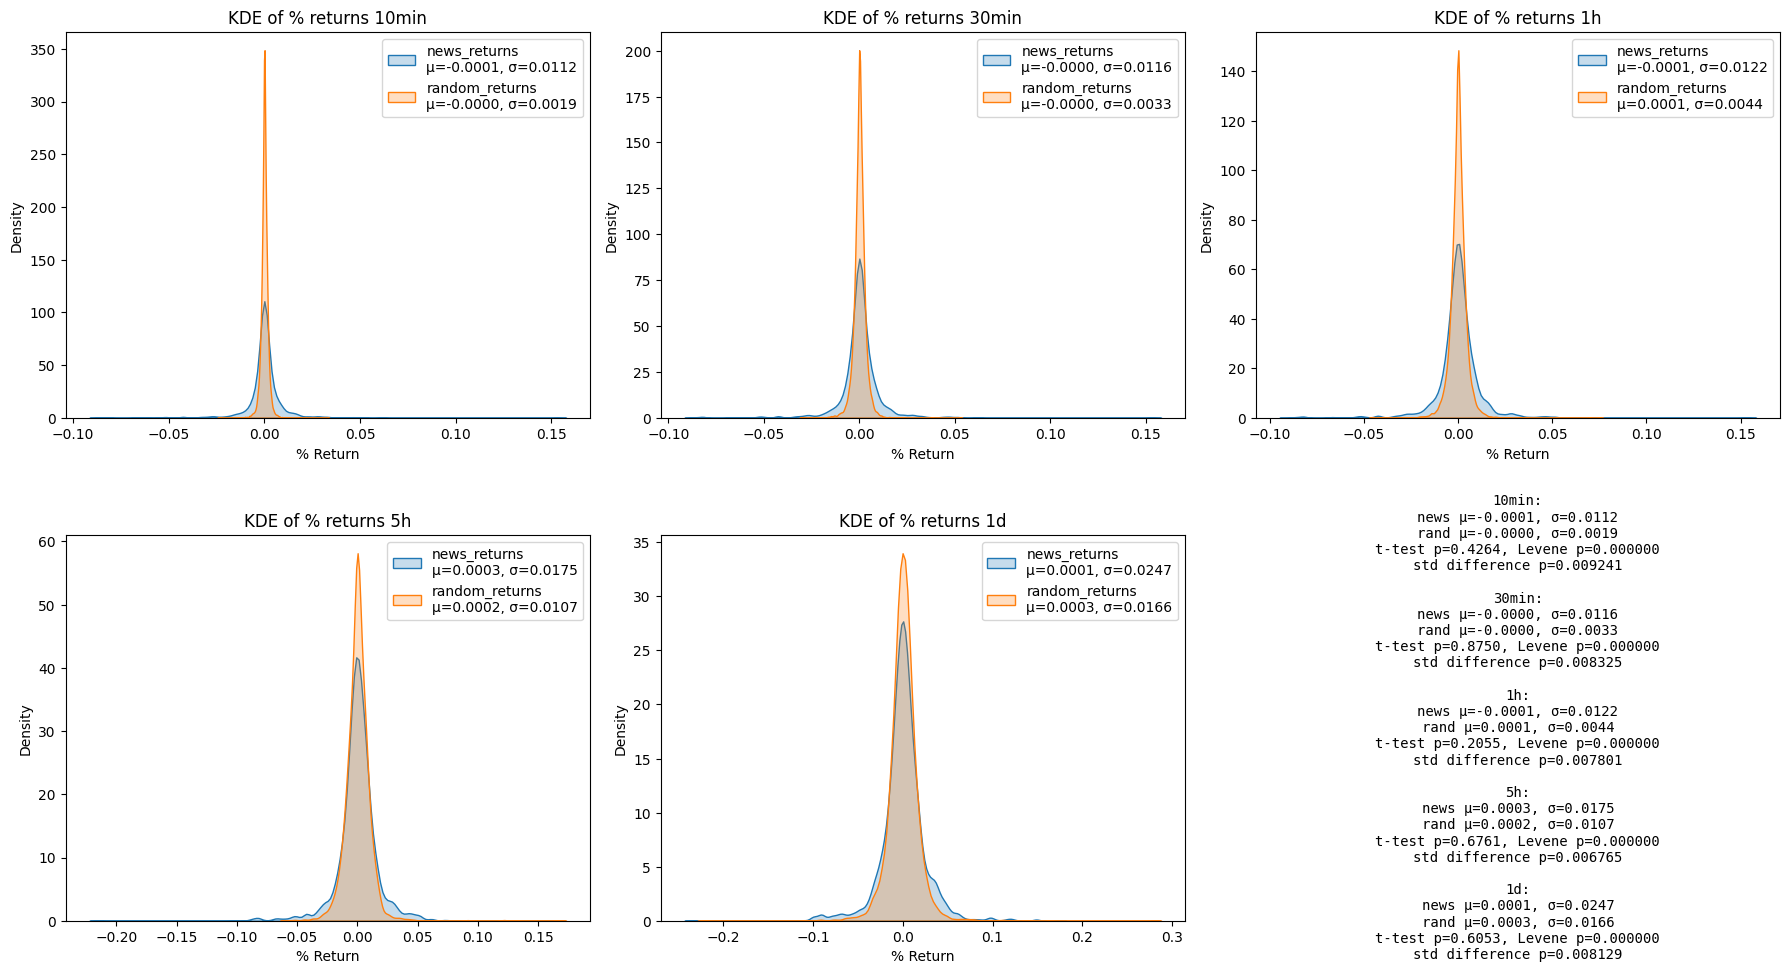

In [35]:
from scipy.stats import levene

plt.figure(figsize=(18, 10))
legend_texts = []
for i in range(5):
    ax = plt.subplot(2, 3, i+1)
    if i < len(news_returns_list):
        sns.kdeplot(news_returns_list[i], label='news_returns', fill=True, ax=ax)
        sns.kdeplot(random_returns_list[i], label='random_returns', fill=True, ax=ax)
        ax.set_title(f'KDE of % returns {timeframes[i]}')
        ax.set_xlabel('% Return')
        mean_news = np.mean(news_returns_list[i])
        std_news = np.std(news_returns_list[i])
        mean_rand = np.mean(random_returns_list[i])
        std_rand = np.std(random_returns_list[i])
        stat, p = levene(news_returns_list[i], random_returns_list[i], center='mean')
        ttest_p = t_tests[i] if i < len(t_tests) else np.nan
        ax.legend([
            f'news_returns\nμ={mean_news:.4f}, σ={std_news:.4f}',
            f'random_returns\nμ={mean_rand:.4f}, σ={std_rand:.4f}',
        ], loc='upper right', fontsize=10)
        legend_texts.append(
            f"{timeframes[i]}:\n"
            f"news μ={mean_news:.4f}, σ={std_news:.4f}\n"
            f"rand μ={mean_rand:.4f}, σ={std_rand:.4f}\n"
            f"t-test p={ttest_p:.4f}, Levene p={p:.6f}\n"
            f"std difference p={std_news - std_rand:.6f}"
        )
    else:
        ax.axis('off')

# Add summary legend to the 6th subplot
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
# Place the legend text in the center of the 6th subplot
ax6.text(
    0.5, 0.5, "\n\n".join(legend_texts),
    ha='center', va='center', fontsize=10, family='monospace'
)
plt.tight_layout()
plt.show()

In [40]:
from scipy.stats import levene

for i, timeframe in enumerate(timeframes):
    print(f"Timeframe: {timeframe}")
    print(f"Mean return after news: {news_returns_list[i].mean():.5f}")
    print(f"Mean return at random: {random_returns_list[i].mean():.5f}")
    print(f"Std return for news: {np.std(news_returns_list[i]):.5f}")
    print(f"Std return for random: {np.std(random_returns_list[i]):.5f}")
    print(f"T-test p-value: {t_tests[i]:.5f}")
    stat, p = levene(news_returns_list[i], random_returns_list[i], center='mean')
    print(f"Levene’s test p-value: {p}")

Timeframe: 10min
Mean return after news: -0.00009
Mean return at random: 0.00002
Std return for news: 0.01116
Std return for random: 0.00191
T-test p-value: 0.21902
Levene’s test p-value: 0.0
Timeframe: 30min
Mean return after news: -0.00003
Mean return at random: -0.00001
Std return for news: 0.01161
Std return for random: 0.00322
T-test p-value: 0.87509
Levene’s test p-value: 0.0
Timeframe: 1h
Mean return after news: -0.00008
Mean return at random: -0.00010
Std return for news: 0.01222
Std return for random: 0.00454
T-test p-value: 0.84935
Levene’s test p-value: 0.0
Timeframe: 5h
Mean return after news: 0.00033
Mean return at random: 0.00027
Std return for news: 0.01748
Std return for random: 0.01018
T-test p-value: 0.82859
Levene’s test p-value: 5.573523746124225e-63
Timeframe: 1d
Mean return after news: 0.00015
Mean return at random: 0.00030
Std return for news: 0.02471
Std return for random: 0.01702
T-test p-value: 0.57067
Levene’s test p-value: 3.283942343438367e-126


models

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import LabelEncoder



c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

# Download necessary NLTK resources
from sklearn.metrics import f1_score, precision_score, recall_score


nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

class MarketSentiment:
    def __init__(self, use_lemmatization=True):
        self.news_data = None
        self.price_data = None
        self.labeled_data = None
        self.model = None
        self.vectorizer = None
        self.important_features = None    
        self.use_lemmatization = use_lemmatization
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stop_words = self._init_stopwords()
        self.vectorizer = None
        self.label_encoder = None
        self.labeled_data = None

    def _init_stopwords(self):
        stop_words = set(stopwords.words('english'))
        financial_stopwords = {
            'stock', 'stocks', 'market', 'markets', 'company',
            'share', 'shares', 'price', 'prices', 'investor',
            'investors', 'trading', 'trader', 'traders', 'report',
            'reports', 'reported', 'quarter', 'quarterly', 'fiscal',
            'financial', 'earnings', 'revenue', 'revenues'
        }
        stop_words.update(financial_stopwords)
        return stop_words

    def clean_text(self, text):
        if not isinstance(text, str):
            return ""

        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)

        tokens = word_tokenize(text)

        if self.use_lemmatization and self.lemmatizer:
            tokens = [self.lemmatizer.lemmatize(t) for t in tokens if t not in self.stop_words]
        else:
            tokens = [t for t in tokens if t not in self.stop_words]

        return ' '.join(tokens)

    def preprocess_data(self, df, max_features=3000, ngram_range=(1, 2), threshold=0.001):
        print("Preprocessing data...")

        df.loc[:, 'text'] = df['title'].fillna('') + ' ' + df['summary'].fillna('')
        df.loc[:, 'future_return'] = (df['future_price'] - df['open_price']) / df['open_price']

        def label_sentiment(return_value, threshold=threshold):
            if return_value > threshold:
                return 'positive'
            elif return_value < -threshold:
                return 'negative'
            else:
                return 'neutral'

        self.labeled_data = df.copy()

        print("Preprocessing text data...")
        self.labeled_data.loc[:, 'cleaned_text'] = self.labeled_data['text'].apply(self.clean_text)
        self.labeled_data.loc[:, 'sentiment_label'] = self.labeled_data['future_return'].apply(label_sentiment)

        self.label_encoder = LabelEncoder()
        self.labeled_data['encoded_target'] = self.label_encoder.fit_transform(self.labeled_data['sentiment_label'])

        # Remove empty texts
        self.labeled_data = self.labeled_data[self.labeled_data['cleaned_text'].str.strip() != '']
        print(f"After preprocessing: {len(self.labeled_data)} articles")

        self.vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
        X = self.vectorizer.fit_transform(self.labeled_data['cleaned_text'])
        X_df = pd.DataFrame(X.toarray(), columns=self.vectorizer.get_feature_names_out())

        return X_df, self.labeled_data, self.label_encoder



    def build_model(self, X_df, target='encoded_target', test_size=0.2, random_state=42):
        """
        Build and evaluate models (Linear, Random Forest, GPU XGBoost RF)
        """
        if self.labeled_data is None or X_df is None:
            print("No data available for model building")
            return

        if target not in self.labeled_data.columns:
            print(f"Target column '{target}' not found in data")
            return

        print(f"Building models to predict {target}...")

        y = self.labeled_data[target].values
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size=test_size, random_state=random_state
        )
        self.X_train = X_train

        print(f"Training set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")


        models = {
            'Logistic Regression': LogisticRegression(),
            'XGBoost Classifier': XGBClassifier(
                        n_estimators=100,
                        learning_rate=1,
                        max_depth=10,
                        subsample=0.8,
                        colsample_bynode=0.8,
                        tree_method='hist',
                        device='cuda',
                        verbosity=1
                    )
        }

        results = {}

        # Train sklearn models
        for name, model in models.items():
            if name == "XGBoost Classifier":
                try:
                    print("Training XGBoost Classifier")

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    class_report = classification_report(y_test, y_pred)
                    acc = accuracy_score(y_test, np.round(y_pred))
                    prec = precision_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                    rec = recall_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                    f1 = f1_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                    print(f"{name} - Accuracy: {acc:.4f}")
                    print(classification_report(y_test, y_pred))

                    # For multiclass ROC/AUC, use probability estimates and specify multi_class
                    if hasattr(model, "predict_proba"):
                        y_proba = model.predict_proba(X_test)
                        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
                    else:
                        auc = None

                    print(class_report)
                    print("acc:",acc)
                    print("prec:",prec)
                    print("rec:",rec)
                    print("f1:",f1)
                    print("auc:", auc)

                    results['XGBoost Classifier'] = {
                        'model': model,
                        'class_report': class_report,
                        'accuracy': acc,
                        'precision': prec,
                        'recall': rec,
                        'auc': auc,
                        'confusion_matrix': confusion_matrix(y_test, np.round(y_pred)),
                        'y_test': y_test,
                        'y_pred': y_pred,
                        'labelencoder': self.label_encoder
                    }
                except Exception as e:
                    print("XGBoost Classifier training failed:", e)
            else:
                print(f"Training {name}...")
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                class_report = classification_report(y_test, y_pred)
                acc = accuracy_score(y_test, np.round(y_pred))
                prec = precision_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                rec = recall_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                f1 = f1_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
                print(f"{name} - Accuracy: {acc:.4f}")
                print(classification_report(y_test, y_pred))

                # For multiclass ROC/AUC, use probability estimates and specify multi_class
                if hasattr(model, "predict_proba"):
                    y_proba = model.predict_proba(X_test)
                    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
                else:
                    auc = None

                print(class_report)
                print("acc:",acc)
                print("prec:",prec)
                print("rec:",rec)
                print("f1:",f1)
                print("auc:", auc)
                
                results[name] = {
                        'model': model,
                        'class_report': class_report,
                        'accuracy': acc,
                        'precision': prec,
                        'recall': rec,
                        'auc': auc,
                        'confusion_matrix': confusion_matrix(y_test, np.round(y_pred)),
                        'y_test': y_test,
                        'y_pred': y_pred,
                        'labelencoder': self.label_encoder
                    }
        
        # Select best model
        best_model_name = max(results, key=lambda k: results[k]['accuracy'])
        self.model = results[best_model_name]['model']
        print(f"Best model: {best_model_name} with accuracy = {results[best_model_name]['accuracy']:.4f}")

        # Extract features only if supported
        if best_model_name in ['Logistic Regression', 'XGBoost Classifier']:
            self.extract_important_features(best_model_name, self.model)

        return results

    
    def extract_important_features(self, model_name, model):
        """
        Extract and visualize important features from the model using SHAP
        """
        print("Extracting important features with SHAP...")

        self.feature_names = self.vectorizer.get_feature_names_out()
        try:
            explainer = shap.Explainer(model, self.X_train)
            shap_values = explainer(self.X_train)

            if shap_values.values.ndim == 3:
                # shape: (n_samples, n_classes, n_features)
                self.mean_shap = (shap_values.values).mean(axis=(0, 2))
                self.abs_mean_shap = np.abs(shap_values.values).mean(axis=(0, 2))
            else:
                # Binary classification or regression
                self.mean_shap = (shap_values.values).mean(axis=0)
                self.abs_mean_shap = np.abs(shap_values.values).mean(axis=0)
            
            # Ensure feature_names matches mean_shap length
            if len(self.mean_shap) != len(self.feature_names):
                print(f"Feature length mismatch: {len(self.feature_names)} features vs {len(self.mean_shap)} SHAP values")
                return None

            # Create DataFrame
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.abs_mean_shap
            }).sort_values(by='importance', ascending=False)

            self.important_features = feature_importance

            print("Top 10 most important features (by SHAP):")
            print(self.important_features.head(10))

            return self.important_features

        except Exception as e:
            print(f"SHAP extraction failed for {model_name}: {e}")
            return None



    def visualize_results(self, results, target='encoded_target'):
        """
        Create visualizations of model performance (regression or classification)
        and top feature importances.
        """
        if results is None or self.important_features is None:
            print("No results or feature importance to visualize")
            return

        plt.style.use('seaborn-v0_8-darkgrid')

        num_models = len(results)
        fig_rows = 2
        fig_cols = max(2, num_models)
        fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(6 * fig_cols, 10))

        if fig_rows == 1:
            axes = [axes]
        elif fig_cols == 1:
            axes = [[ax] for ax in axes]

        for i, (name, result) in enumerate(results.items()):
            y_test = result['y_test']
            y_pred = result['y_pred']

            ax = axes[0][i]

            # Determine classification or regression
            is_classification = np.array_equal(np.unique(y_test), [0, 1]) or np.issubdtype(y_test.dtype, np.integer)

            if is_classification:
                cm = confusion_matrix(y_test, np.round(y_pred))
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(ax=ax, cmap='Blues', colorbar=False)
                ax.set_title(f"{name} - Confusion Matrix")

                try:
                    auc = roc_auc_score(y_test, y_pred)
                    ax.text(0.05, 0.95, f"AUC = {auc:.4f}", transform=ax.transAxes,
                            fontsize=12, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                except Exception:
                    pass
            else:
                ax.scatter(y_test, y_pred, alpha=0.5)
                ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
                ax.set_title(f'{name}: Actual vs Predicted {target}')
                ax.set_xlabel('Actual')
                ax.set_ylabel('Predicted')
                ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}",
                        transform=ax.transAxes, fontsize=12, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 2. Feature importance bar chart
        top_n = min(15, len(self.important_features))
        ax = axes[1][0]
        sns.barplot(x='importance', y='feature', data=self.important_features.head(top_n), ax=ax)
        ax.set_title(f'Top {top_n} Important Features')
        ax.set_xlabel('Importance')

        # 3. Target distribution
        ax = axes[1][1]
        if np.issubdtype(self.labeled_data[target].dtype, np.integer):
            sns.countplot(x=self.labeled_data[target], ax=ax)
        else:
            sns.histplot(self.labeled_data[target], kde=True, ax=ax)
        ax.set_title(f'Distribution of {target}')
        ax.set_xlabel(target)

        plt.tight_layout()
        plt.show()




        
    def create_sentiment_lexicon(self, threshold=0.001):
        """
        Create a market-based sentiment lexicon using SHAP values.
        Supports models with precomputed SHAP values (from extract_important_features).
        Includes both raw and absolute mean SHAP values.
        """
        if self.model is None or self.important_features is None:
            print("No model or feature importance available")
            return None

        print("Creating market-based sentiment lexicon using SHAP...")

        if not hasattr(self, 'X_train') or not hasattr(self, 'vectorizer'):
            print("X_train or vectorizer missing.")
            return None

        try:
            import shap
        except ImportError:
            print("SHAP not installed. Please install with `pip install shap`.")
            return None

        if self.feature_names is None:
            self.feature_names = self.vectorizer.get_feature_names_out()

        # Compute SHAP values again if not stored
        if self.mean_shap is None or self.abs_mean_shap is None:
            try:
                explainer = shap.Explainer(self.model, self.X_train)
                shap_values = explainer(self.X_train)

                # Handle multi-class case: average across samples and classes
                if shap_values.values.ndim == 3:
                    self.mean_shap = (shap_values.values).mean(axis=(0, 2))         # shape: (n_features,), importance
                    self.abs_mean_shap = np.abs(shap_values.values).mean(axis=(0, 2)) # direction
                else:
                    self.mean_shap = (shap_values.values).mean(axis=0)              # shape: (n_features,), importance
                    self.abs_mean_shap = np.abs(shap_values.values).mean(axis=0)    # direction
            except Exception as e:
                print("SHAP explanation failed:", str(e))
                return None

        sentiment_dict = {}
        for feature, coef, abs_coef in zip(self.feature_names, self.mean_shap, self.abs_mean_shap):
            if abs_coef > threshold:
                sentiment = 'positive' if coef > 0 else 'negative'
                sentiment_dict[feature] = {
                    'sentiment': sentiment,
                    'direction': float(coef),
                    'importance': float(abs_coef)
                }

        lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
        lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
        lexicon = lexicon.sort_values('importance', ascending=False)

        print(f"Created sentiment lexicon with {len(lexicon)} words")

        print("\nTop positive words:")
        print(lexicon[lexicon['sentiment'] == 'positive'].sort_values('direction', ascending=False).head(10))

        print("\nTop negative words:")
        print(lexicon[lexicon['sentiment'] == 'negative'].sort_values('direction', ascending=False).tail(10))

        return lexicon



    
    def test_shap(self):
        explainer = shap.Explainer(self.model, self.X_train)
        shap_values = explainer(self.X_train)
        return explainer, shap_values

In [12]:
complete_df = get_complete_df(tickers, '+10 minutes')

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

Controlls / checks

In [66]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16210 entries, 0 to 26387
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ticker                         16210 non-null  object 
 1   url                            16210 non-null  object 
 2   title                          16210 non-null  object 
 3   summary                        16210 non-null  object 
 4   source_domain                  16210 non-null  object 
 5   closest_time_before_published  16210 non-null  object 
 6   future_time                    16210 non-null  object 
 7   adjusted_future_time           16210 non-null  object 
 8   open_price                     16210 non-null  float64
 9   future_price                   16210 non-null  float64
 10  time_published                 16210 non-null  object 
dtypes: float64(2), object(9)
memory usage: 1.5+ MB


In [89]:
# Count NaN values for each column in complete_df
print(complete_df.isna().sum())

ticker                           0
url                              0
title                            0
summary                          0
source_domain                    0
closest_time_before_published    0
future_time                      0
adjusted_future_time             0
open_price                       0
future_price                     0
time_published                   0
text                             0
future_return                    0
cleaned_text                     0
sentiment_label                  0
encoded_target                   0
dtype: int64


In [18]:
# Initialize and preprocess
sentiment_model = MarketSentiment(use_lemmatization=True)

X_df, data, labelencoder = sentiment_model.preprocess_data(complete_df, 
                                            max_features=3000, 
                                            ngram_range=(1, 2), 
                                            threshold=0.002)

Preprocessing data...
Preprocessing text data...
After preprocessing: 16210 articles


In [92]:
sentiment_model.labeled_data["sentiment_label"].value_counts()

sentiment_label
neutral     6368
positive    5121
negative    4721
Name: count, dtype: int64

In [68]:
print(data["encoded_target"].head(3).values)
print(data["sentiment_label"].head(3).values)

[1 0 2]
['neutral' 'negative' 'positive']


In [17]:
labelencoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
sentiment_model = MarketSentiment()

X_df, data, labelencoder = sentiment_model.preprocess_data(complete_df,  
                                            max_features=5000, 
                                            ngram_range=(1, 2),  
                                            threshold=0.002)

TypeError: MarketSentiment.preprocess_data() got an unexpected keyword argument 'use_lemmatization'

Building models to predict encoded_target...
Training set: 12968 samples, Test set: 3242 samples
Training Logistic Regression...
Logistic Regression - Accuracy: 0.4457
              precision    recall  f1-score   support

           0       0.37      0.28      0.32       930
           1       0.49      0.64      0.56      1274
           2       0.42      0.36      0.39      1038

    accuracy                           0.45      3242
   macro avg       0.43      0.43      0.42      3242
weighted avg       0.43      0.45      0.43      3242

              precision    recall  f1-score   support

           0       0.37      0.28      0.32       930
           1       0.49      0.64      0.56      1274
           2       0.42      0.36      0.39      1038

    accuracy                           0.45      3242
   macro avg       0.43      0.43      0.42      3242
weighted avg       0.43      0.45      0.43      3242

acc: 0.445712523133868
prec: 0.43364291016897455
rec: 0.44571252313386

100%|===================| 38798/38904 [04:13<00:00]        

Top 10 most important features (by SHAP):
       feature  importance
2643    tariff    0.048175
1729    nasdaq    0.037742
1818      nyse    0.031397
2972      year    0.028757
2720       top    0.025735
389        buy    0.022543
384   business    0.020738
2707     today    0.020333
117    analyst    0.020306
1812    nvidia    0.020277


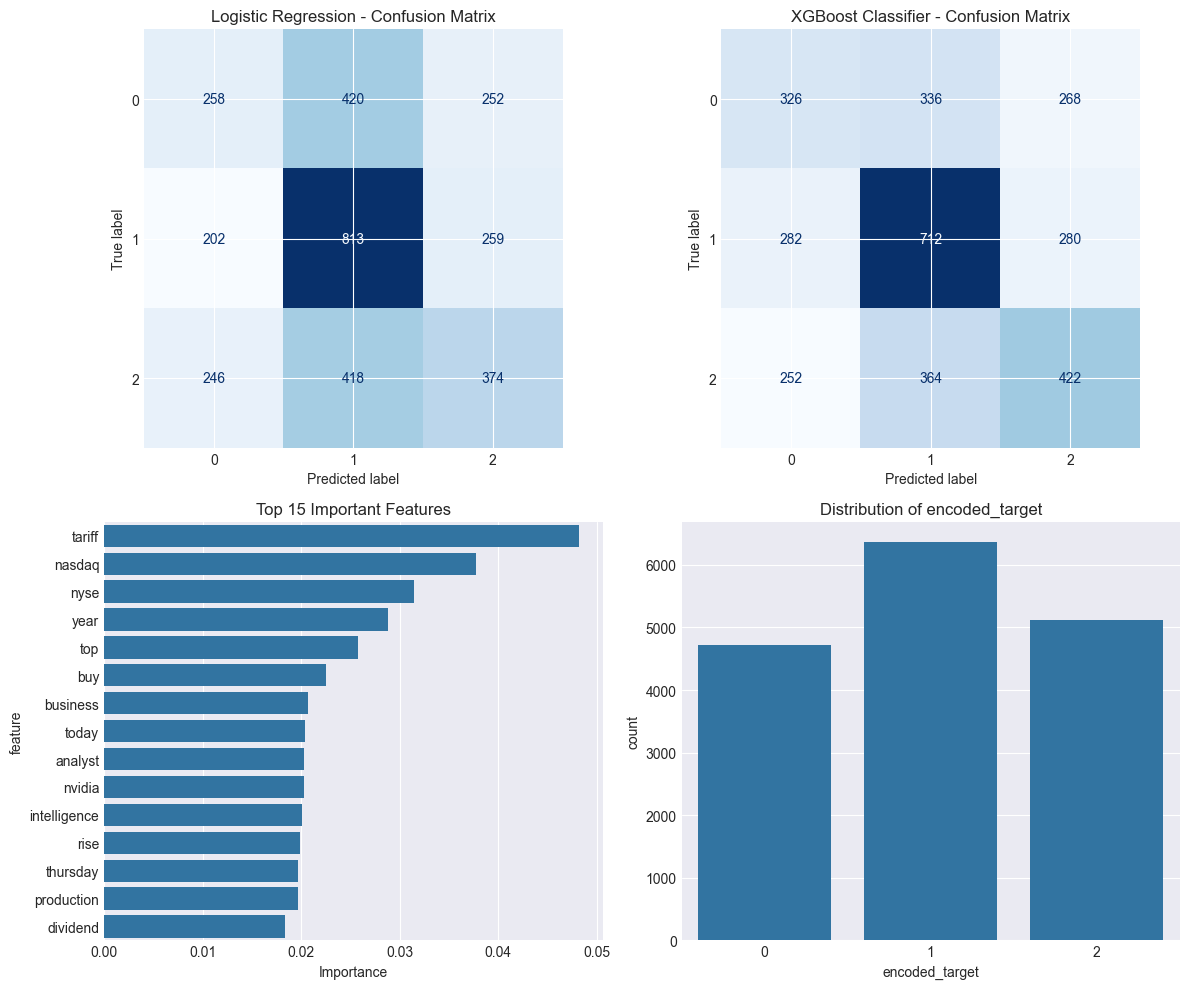

Creating market-based sentiment lexicon using SHAP...
Created sentiment lexicon with 891 words

Top positive words:
          word sentiment  direction  importance
147      china  positive   0.007671    0.013472
206        day  positive   0.006409    0.013965
552       nyse  positive   0.006152    0.031397
494        may  positive   0.006052    0.008562
676    remains  positive   0.005951    0.009847
271  exclusive  positive   0.005764    0.009283
803   thursday  positive   0.005601    0.019718
724        set  positive   0.005282    0.009428
264   estimate  positive   0.004494    0.008040
811        top  positive   0.004457    0.025735

Top negative words:
                word sentiment  direction  importance
804             time  negative  -0.005695    0.016518
673          reflect  negative  -0.006133    0.013347
16             ahead  negative  -0.006274    0.014776
662          reading  negative  -0.006462    0.008567
136  celsius holding  negative  -0.006522    0.007735
644       p

In [19]:

# Build model
results = sentiment_model.build_model(X_df, target='encoded_target', test_size=0.2, random_state=42)

# Visualize results
sentiment_model.visualize_results(results)

# Generate lexicon
lexicon = sentiment_model.create_sentiment_lexicon()


fix shap for xbgoost classifier

In [88]:
lexicon.sort_values(by='direction', ascending=False)

,word,sentiment,direction,importance
203,etf,positive,2.436212e-17,0.003400
379,mark,positive,2.377508e-17,0.007020
309,index,positive,1.285433e-17,0.005276
337,johnson,positive,1.172035e-17,0.004936
416,netflix,positive,1.006254e-17,0.003550
...,...,...,...,...
493,procter,negative,-1.206735e-17,0.004550
358,left,negative,-1.248419e-17,0.002673
641,trump tariff,negative,-1.358687e-17,0.001861
295,holding,negative,-1.767466e-17,0.005719


In [26]:
results["XGBoost Classifier"]

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=0.8,
               colsample_bytree=None, device='cuda', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None, ...),
 'accuracy': 0.45033929673041334,
 'class_report': '              precision    recall  f1-score   support\n\n           0       0.38      0.35      0.36       930\n           1       0.50      0.56      0.53      1274\n    

In [25]:
target='encoded_target'
# X_df, data, labelencoder
y = data[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42
)

model = XGBClassifier(
    n_estimators=100,
    learning_rate=1,
    max_depth=10,
    subsample=0.8,
    colsample_bynode=0.8,
    tree_method='hist',
    device='cuda',
    verbosity=1
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.8,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
acc = accuracy_score(y_test, np.round(y_pred))
prec = precision_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
rec = recall_score(y_test, np.round(y_pred), zero_division=0, average='weighted')
f1 = f1_score(y_test, np.round(y_pred), zero_division=0, average='weighted')

# For multiclass ROC/AUC, use probability estimates and specify multi_class
if hasattr(model, "predict_proba"):
	y_proba = model.predict_proba(X_test)
	auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
else:
	auc = None

print(class_report)
print("acc:",acc)
print("prec:",prec)
print("rec:",rec)
print("f1:",f1)
print("auc:", auc)


              precision    recall  f1-score   support

           0       0.38      0.37      0.37       930
           1       0.50      0.55      0.52      1274
           2       0.44      0.41      0.42      1038

    accuracy                           0.45      3242
   macro avg       0.44      0.44      0.44      3242
weighted avg       0.45      0.45      0.45      3242

acc: 0.45064774830351634
prec: 0.44802005487019897
rec: 0.45064774830351634
f1: 0.4486853010466601
auc: 0.6136191486319235


In [103]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import io

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


def plot_model_results(Y_test, Y_pred, Y_prob, Class_report, Labelencoder, Acc, Prec, Rec, F1, Auc, name):
    plt.figure(figsize=(18, 5))
    plt.suptitle(f"{name} Results", fontsize=16)
    # Compute ROC curve and ROC area for each class
    n_classes = len(labelencoder.classes_)
    # Binarize the output
    y_test_bin = label_binarize(Y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], Y_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], Y_prob[:, i])

    # 1. Confusion Matrix
    plt.subplot(1, 4, 1)
    cm = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, display_labels=Labelencoder.classes_, cmap='Blues', colorbar=False, ax=plt.gca())
    plt.title("Confusion Matrix")

    # 2. Classification Report Table
    plt.subplot(1, 4, 2)
    # Parse the classification report string into a table

    report_df = pd.read_fwf(io.StringIO(Class_report), index_col=0)
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
    plt.title("Classification Report")
    plt.yticks(rotation=0)

    # 3. ROC Curves for each class
    plt.subplot(1, 4, 3)
    # Define n_classes based on labelencoder or y_test
    n_classes = len(Labelencoder.classes_)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC={roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()

    # 4. Metrics Box
    plt.subplot(1, 4, 4)
    metrics = {
        "Accuracy": Acc,
        "Precision": Prec,
        "Recall": Rec,
        "F1 Score": F1,
        "AUC": Auc,
        "Class 0 Support": int(report_df.loc['0', 'support']),
        "Class 1 Support": int(report_df.loc['1', 'support']),
        "Class 2 Support": int(report_df.loc['2', 'support']),
    }
    metrics.update({f"AUC Class {i}": float(roc_auc[i]) for i in range(n_classes)})
    metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
    plt.axis('off')
    plt.text(0.1, 0.5, metrics_text, fontsize=14, va='center')

    plt.tight_layout()
    plt.show()
    return metrics_text

#metric = plot_model_results(Y_test=y_test, Y_pred=y_pred, Y_prob=y_proba, Class_report=class_report, Labelencoder=labelencoder, Acc=acc, Prec=prec, Rec=rec, F1=f1)

In [96]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
print(explainer, shap_values)

100%|===================| 38784/38904 [04:24<00:00]        

<shap.explainers._tree.TreeExplainer object at 0x000001B0079B1C70> .values =
array([[[ 0.00000000e+00,  0.00000000e+00, -1.40066510e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.41170144e-03,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00, -8.82374331e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-5.81752509e-05,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00, -1.40066510e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+

In [97]:
shap_values.values.shape

(12968, 3000, 3)

In [ ]:
print(shap_values.shape) # (12968, 3000, 3)
print((np.abs(shap_values.values).mean(axis=(0, 1))).shape) # (3,)
print(X_df.columns.shape) # (3000,)

(12968, 3000, 3)
(3,)
(3000,)


In [26]:
X_df.columns.shape

(3000,)

In [98]:
(shap_values.values).mean(axis=(0, 2))

array([-2.31200724e-03,  2.32539954e-05, -3.48974983e-05, ...,
        6.69372812e-04,  0.00000000e+00, -1.75381895e-04], shape=(3000,))

In [99]:
shap_values.values.mean(axis=(0, 2))

array([-2.31200724e-03,  2.32539954e-05, -3.48974983e-05, ...,
        6.69372812e-04,  0.00000000e+00, -1.75381895e-04], shape=(3000,))

In [100]:
mean_shap_abs = np.abs(shap_values.values).mean(axis=(0, 2))
mean_shap = (shap_values.values).mean(axis=(0, 2))
feature_names = X_df.columns
if len(mean_shap) != len(feature_names):
    print(f"Mismatch: {len(mean_shap)} shap vs {len(feature_names)} features")
    


feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_shap_abs,
    'direction': mean_shap
}).sort_values(by='importance', ascending=False)

In [102]:
sentiment_dict = {}
for feature, coef, abs_coef in zip(feature_names, mean_shap, mean_shap_abs):
    if abs_coef > 0.002:
        sentiment = 'positive' if coef > 0 else 'negative'
        sentiment_dict[feature] = {
            'sentiment': sentiment,
            'direction': float(coef),
            'importance': float(abs_coef)
        }

lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
lexicon = lexicon.sort_values('importance', ascending=False)

In [ ]:
mean_shap_abs = np.abs(shap_values.values).mean(axis=(0, 2))
mean_shap = (shap_values.values).mean(axis=(0, 2))
feature_names = X_df.columns
if len(mean_shap) != len(feature_names):
    print(f"Mismatch: {len(mean_shap)} shap vs {len(feature_names)} features")

sentiment_dict = {}
for feature, coef, abs_coef in zip(feature_names, mean_shap, mean_shap_abs):
    if abs_coef > 0.002:
        sentiment = 'positive' if coef > 0 else 'negative'
        sentiment_dict[feature] = {
            'sentiment': sentiment,
            'direction': float(coef),
            'importance': float(abs_coef)
        }

lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
lexicon = lexicon.sort_values('importance', ascending=False)

In [77]:
lexicon.shape

(643, 4)

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

mean_shap_abs = np.abs(shap_values.values).mean(axis=(0, 2))
mean_shap = (shap_values.values).mean(axis=(0, 2))
feature_names = X_df.columns
if len(mean_shap) != len(feature_names):
    print(f"Mismatch: {len(mean_shap)} shap vs {len(feature_names)} features")

sentiment_dict = {}
for feature, coef, abs_coef in zip(feature_names, mean_shap, mean_shap_abs):
    if abs_coef > 0.002:
        sentiment = 'positive' if coef > 0 else 'negative'
        sentiment_dict[feature] = {
            'sentiment': sentiment,
            'direction': float(coef),
            'importance': float(abs_coef)
        }

lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
lexicon = lexicon.sort_values('importance', ascending=False)

In [103]:
lexicon.sort_values('importance', ascending=False)

,word,sentiment,direction,importance
547,tariff,negative,-0.004453,0.048175
362,nasdaq,negative,-0.002932,0.037742
381,nyse,positive,0.006152,0.031397
620,year,negative,-0.002284,0.028757
569,top,positive,0.004457,0.025735
...,...,...,...,...
36,approach,negative,-0.000103,0.002024
147,different,positive,0.001250,0.002024
580,tv,negative,-0.000381,0.002017
10,adoption,positive,0.000830,0.002012


In [72]:
sentiment_model.create_sentiment_lexicon()

Creating market-based sentiment lexicon...
Sentiment lexicon creation only implemented for Linear Regression


hypertuning xgboost classifier

In [103]:
sentiment_model.labeled_data["sentiment_label"].value_counts()

sentiment_label
neutral     6368
positive    5121
negative    4721
Name: count, dtype: int64

In [40]:
sentiment_model = MarketSentiment(use_lemmatization=True)

# Preprocess your data as you already do:
X_df, data, labelencoder = sentiment_model.preprocess_data(
    complete_df, max_features=5000, ngram_range=(1, 2), threshold=0.002
)

Preprocessing data...
Preprocessing text data...
After preprocessing: 16210 articles


In [ ]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


y = data['encoded_target'].values
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

def evaluate_model_macro_f1(n_estimators, learning_rate, max_depth, subsample, colsample_bynode):
    model = XGBClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        subsample=float(subsample),
        colsample_bynode=float(colsample_bynode),
        tree_method='hist',
        device='cuda',
        use_label_encoder=False,
        eval_metric='mlogloss',
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    return macro_f1

from bayes_opt import BayesianOptimization

# Define bounds
pbounds = {
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'colsample_bynode': (0.5, 1.0)
}

optimizer = BayesianOptimization(
    f=evaluate_model_macro_f1,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=20, n_iter=100)

# Get best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

# Train final model
model = XGBClassifier(
    **best_params,
    tree_method='hist',
    device='cuda',
    verbosity=1,
    eval_metric='mlogloss'
)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
report = classification_report(y_test, y_pred)

print(report)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")




Preprocessing data...
Preprocessing text data...
After preprocessing: 16210 articles
|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.4488    | 0.6873    | 0.2857    | 8.124     | 199.7     | 0.578     |
| 2         | 0.3935    | 0.578     | 0.02684   | 9.063     | 200.3     | 0.854     |
| 3         | 0.4313    | 0.5103    | 0.2913    | 8.827     | 103.1     | 0.5909    |
| 4         | 0.4168    | 0.5917    | 0.09823   | 6.673     | 158.0     | 0.6456    |
| 5         | 0.3692    | 0.8059    | 0.05045   | 5.045     | 141.6     | 0.728     |
| 6         | 0.4171    | 0.8926    | 0.06791   | 6.6       | 198.1     | 0.5232    |
| 7         | 0.3764    | 0.8038    | 0.05945   | 3.455     | 287.2     | 0.9828    |
| 8         | 0.3913    | 0.9042    | 0.09834   | 3.684     | 221.1     | 0.7201    |
| 9         | 0.4118    | 0.561     | 0.1536    | 3.241

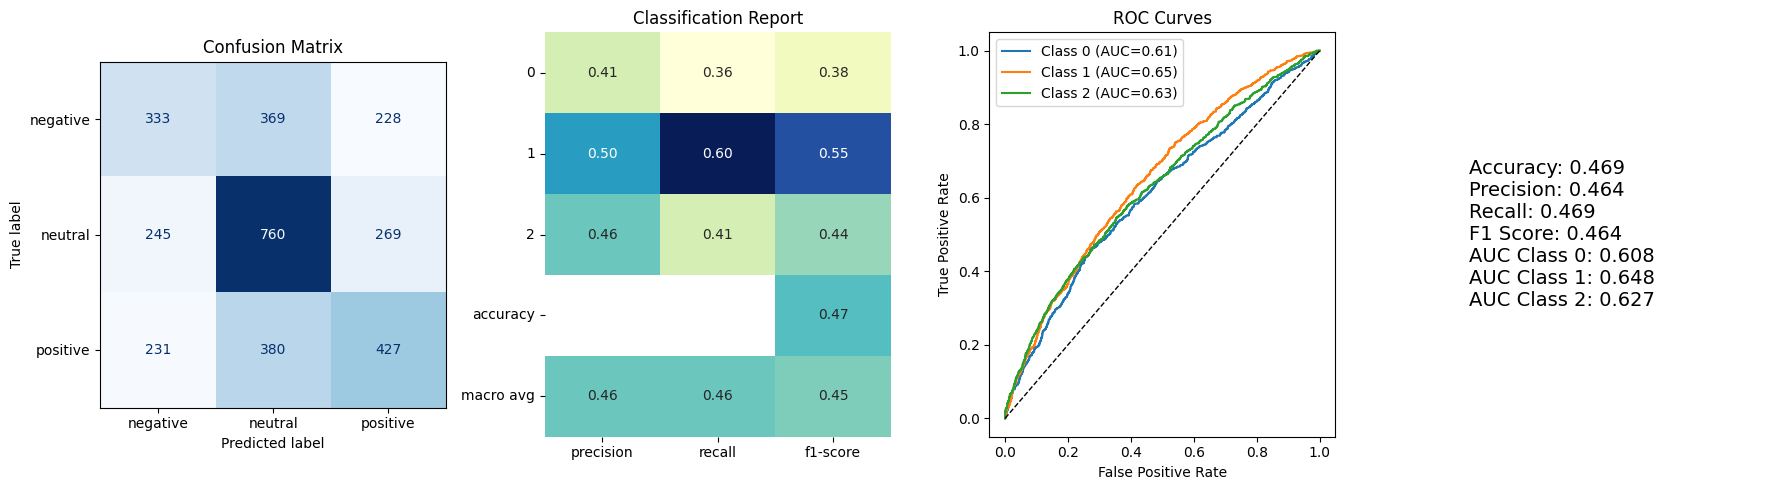

In [ ]:
new_opti_metric = plot_model_results(Y_test=y_test, Y_pred=y_pred, Y_prob=y_proba, Class_report=report, Labelencoder=labelencoder, Acc=acc, Prec=prec, Rec=rec, F1=f1, Auc=auc)

In [13]:
new_opti_metric

'Accuracy: 0.469\nPrecision: 0.464\nRecall: 0.469\nF1 Score: 0.464\nAUC Class 0: 0.608\nAUC Class 1: 0.648\nAUC Class 2: 0.627'

In [97]:
import pandas as pd

# Convert best_params to a DataFrame and save to CSV
pd.DataFrame([best_params]).to_csv("best_xgb_params_new.csv", index=False)

In [99]:
X_df, data, labelencoder = sentiment_model.preprocess_data(
    complete_df, max_features=5000, ngram_range=(1, 2), threshold=0.002
)
y = data['encoded_target'].values
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

Preprocessing data...
Preprocessing text data...
After preprocessing: 16210 articles


optimised model

In [100]:
sentiment_model = MarketSentiment(use_lemmatization=True)

# Preprocess your data as you already do:
X_df, data, labelencoder = sentiment_model.preprocess_data(
    complete_df, max_features=5000, ngram_range=(1, 2), threshold=0.002
)


model_opti = XGBClassifier(
    **best_params,
    tree_method='hist',
    device='cuda',
    verbosity=1,
)
model_opti.fit(X_train, y_train)

# Predictions and evaluation
y_pred_opti = model_opti.predict(X_test)
y_proba_opti = model_opti.predict_proba(X_test)
acc_opti = accuracy_score(y_test, y_pred_opti)
prec_opti = precision_score(y_test, y_pred_opti, average='weighted', zero_division=0)
rec_opti = recall_score(y_test, y_pred_opti, average='weighted', zero_division=0)
f1_opti = f1_score(y_test, y_pred_opti, average='weighted', zero_division=0)
report_opti = classification_report(y_test, y_pred_opti)

if hasattr(model_opti, "predict_proba"):
	y_proba_opti = model_opti.predict_proba(X_test)
	auc_opti = roc_auc_score(y_test, y_proba_opti, multi_class='ovr')
else:
	auc_opti = None


print(report_opti)
print(f"Accuracy: {acc_opti:.4f}")
print(f"Precision: {prec_opti:.4f}")
print(f"Recall: {rec_opti:.4f}")
print(f"F1 Score: {f1_opti:.4f}")
print(f"AUC: {auc_opti:.4f}")


Preprocessing data...
Preprocessing text data...
After preprocessing: 16210 articles
              precision    recall  f1-score   support

           0       0.41      0.36      0.38       930
           1       0.50      0.60      0.55      1274
           2       0.46      0.41      0.44      1038

    accuracy                           0.47      3242
   macro avg       0.46      0.46      0.45      3242
weighted avg       0.46      0.47      0.46      3242

Accuracy: 0.4688
Precision: 0.4640
Recall: 0.4688
F1 Score: 0.4639
AUC: 0.6277


original model

In [101]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=1,
    max_depth=10,
    subsample=0.8,
    colsample_bynode=0.8,
    tree_method='hist',
    device='cuda',
    verbosity=1,
    
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0, average='weighted')
rec = recall_score(y_test, y_pred, zero_division=0, average='weighted')
f1 = f1_score(y_test, y_pred, zero_division=0, average='weighted')

# For multiclass ROC/AUC, use probability estimates and specify multi_class
if hasattr(model, "predict_proba"):
	y_proba = model.predict_proba(X_test)
	auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
else:
	auc = None

print(class_report)
print("acc:",acc)
print("prec:",prec)
print("rec:",rec)
print("f1:",f1)
print("auc:", auc)

              precision    recall  f1-score   support

           0       0.38      0.37      0.37       930
           1       0.50      0.55      0.52      1274
           2       0.44      0.41      0.42      1038

    accuracy                           0.45      3242
   macro avg       0.44      0.44      0.44      3242
weighted avg       0.45      0.45      0.45      3242

acc: 0.45064774830351634
prec: 0.44802005487019897
rec: 0.45064774830351634
f1: 0.4486853010466601
auc: 0.6136191486319235


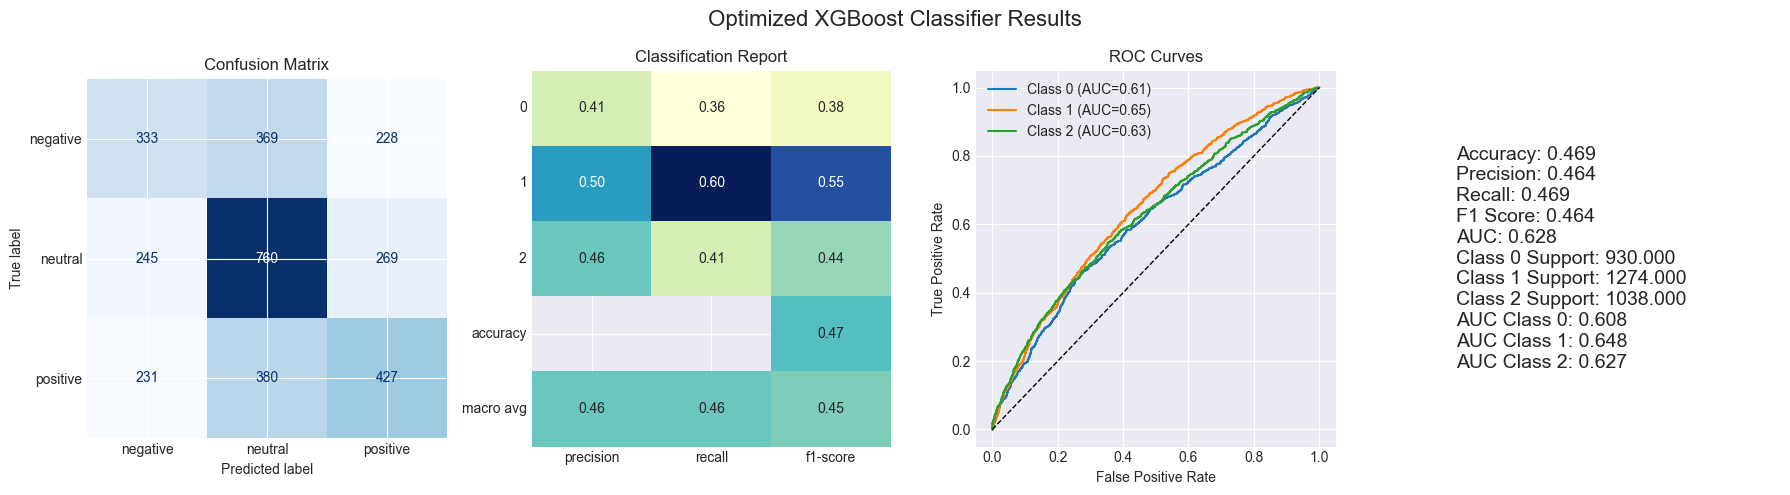

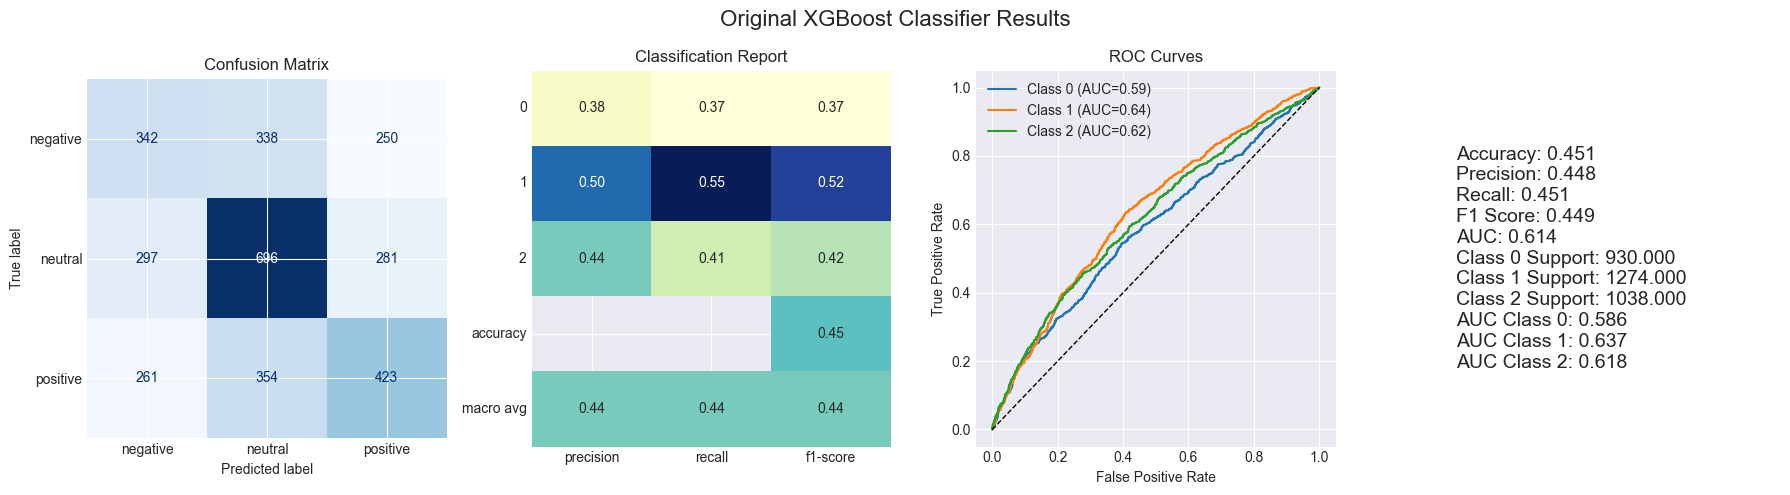

In [104]:
#opti
opti_metric = plot_model_results(Y_test=y_test, Y_pred=y_pred_opti, 
                                 Y_prob=y_proba_opti, Class_report=report_opti, 
                                 Labelencoder=labelencoder, Acc=acc_opti, 
                                 Prec=prec_opti, Rec=rec_opti, 
                                 F1=f1_opti, Auc=auc_opti, name="Optimized XGBoost Classifier")
#Orignal
original_metric = plot_model_results(Y_test=y_test, Y_pred=y_pred, 
                                     Y_prob=y_proba, Class_report=class_report, 
                                     Labelencoder=labelencoder, Acc=acc, 
                                     Prec=prec, Rec=rec, 
                                     F1=f1, Auc=auc, name="Original XGBoost Classifier")

In [20]:
sentiment_model = MarketSentiment(use_lemmatization=True)

# Preprocess your data as you already do:
X_df, data, labelencoder = sentiment_model.preprocess_data(
    complete_df, max_features=5000, ngram_range=(1, 2), threshold=0.002
)
y = data['encoded_target'].values
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

Preprocessing data...
Preprocessing text data...
After preprocessing: 16210 articles


In [21]:
import pandas as pd

# Load best XGBoost parameters from CSV
best_params_df = pd.read_csv("best_xgb_params_new.csv")
best_params = best_params_df.iloc[0].to_dict()
# Ensure integer parameters are cast correctly
if 'n_estimators' in best_params:
    best_params['n_estimators'] = int(best_params['n_estimators'])
if 'max_depth' in best_params:
    best_params['max_depth'] = int(best_params['max_depth'])

print(best_params)

{'colsample_bynode': 0.6988940467829937, 'learning_rate': 0.2588779055271398, 'max_depth': 9, 'n_estimators': 227, 'subsample': 0.7978944109155615}


In [22]:
# Train final model


model = XGBClassifier(
    **best_params,
    tree_method='hist',
    device='cuda',
    verbosity=1,
    eval_metric='mlogloss'
)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
report = classification_report(y_test, y_pred)

print(report)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
plot_model_results(Y_test=y_test, Y_pred=y_pred, Y_prob=y_proba, Class_report=report, Labelencoder=labelencoder, Acc=acc, Prec=prec, Rec=rec, F1=f1)

              precision    recall  f1-score   support

           0       0.41      0.36      0.38       930
           1       0.50      0.60      0.55      1274
           2       0.46      0.41      0.44      1038

    accuracy                           0.47      3242
   macro avg       0.46      0.46      0.45      3242
weighted avg       0.46      0.47      0.46      3242

Accuracy: 0.4688
Precision: 0.4640
Recall: 0.4688
F1 Score: 0.4639
AUC: 0.6277


NameError: name 'plot_model_results' is not defined

In [42]:
import shap
import pandas as pd
import numpy as np

# Assume model is trained and X_train is your feature matrix (not a DataFrame)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)  # shap_values.values shape: (n_samples, n_features, n_classes)

# Get feature names
feature_names = sentiment_model.vectorizer.get_feature_names_out()

# Compute mean SHAP values per class
# Result: DataFrame with shape (n_features, n_classes)
mean_shap_per_class = pd.DataFrame(
    shap_values.values.mean(axis=0),  # shape: (n_features, n_classes)
    index=feature_names,
    columns=[f"class_{i}" for i in range(shap_values.values.shape[2])]
)

# Optional: Melt to long format if you want one row per feature-class pair
shap_long = mean_shap_per_class.reset_index().melt(id_vars="index", var_name="class", value_name="mean_direction")
shap_long.rename(columns={"index": "feature"}, inplace=True)

# View result
print(shap_long.head())


100%|===================| 38888/38904 [10:10<00:00]        

       feature    class  mean_direction
0         aapl  class_0       -0.000014
1  aapl amazon  class_0        0.000006
2   aapl apple  class_0       -0.000289
3    aapl msft  class_0        0.000000
4       abbott  class_0        0.000000


In [46]:
# Use mean_shap_per_class and feature_names already available
df_shap = mean_shap_per_class.copy()
df_shap['importance'] = df_shap.abs().max(axis=1)
df_shap = df_shap.reset_index().rename(columns={'index': 'feature'})
df_shap = df_shap[['feature', 'class_0', 'class_1', 'class_2', 'importance']]
df_shap.head()

,feature,class_0,class_1,class_2,importance
0,aapl,-0.000014,0.000257,0.000922,0.000922
1,aapl amazon,0.000006,0.000000,-0.000951,0.000951
2,aapl apple,-0.000289,0.000000,0.000000,0.000289
3,aapl msft,0.000000,0.000000,-0.000367,0.000367
4,abbott,0.000000,0.000000,0.000000,0.000000


In [47]:
df_shap.sort_values(by='importance', ascending=False, inplace=True)

In [48]:
df_shap

,feature,class_0,class_1,class_2,importance
4387,tariff,-0.006095,0.025160,-0.000128,0.025160
1490,etf,0.000609,-0.016533,0.001542,0.016533
1996,hathaway,0.000000,0.000000,-0.016254,0.016254
3113,opening bell,-0.012404,0.001043,0.000000,0.012404
1030,corp,0.002994,-0.012395,0.000037,0.012395
...,...,...,...,...,...
4926,worldwide,0.000000,0.000000,0.000000,0.000000
4927,worried,0.000000,0.000000,0.000000,0.000000
2514,letter,0.000000,0.000000,0.000000,0.000000
2516,level dynamic,0.000000,0.000000,0.000000,0.000000


In [43]:
shap_long

,feature,class,mean_direction
0,aapl,class_0,-0.000014
1,aapl amazon,class_0,0.000006
2,aapl apple,class_0,-0.000289
3,aapl msft,class_0,0.000000
4,abbott,class_0,0.000000
...,...,...,...
14995,zacks style,class_2,0.000000
14996,zacks top,class_2,0.000000
14997,zero,class_2,0.000000
14998,zone,class_2,0.000020


In [131]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
print(explainer, shap_values)

mean_shap_abs = np.abs(shap_values.values).mean(axis=(0, 2))
mean_shap = (shap_values.values).mean(axis=(0, 2))
feature_names = X_df.columns
if len(mean_shap) != len(feature_names):
    print(f"Mismatch: {len(mean_shap)} shap vs {len(feature_names)} features")

sentiment_dict = {}
for feature, coef, abs_coef in zip(feature_names, mean_shap, mean_shap_abs):
    if abs_coef > 0.002:
        sentiment = 'positive' if coef > 0 else 'negative'
        sentiment_dict[feature] = {
            'sentiment': sentiment,
            'direction': float(coef),
            'importance': float(abs_coef)
        }

lexicon = pd.DataFrame.from_dict(sentiment_dict, orient='index')
lexicon = lexicon.reset_index().rename(columns={'index': 'word'})
lexicon = lexicon.sort_values('importance', ascending=False)

100%|===================| 38836/38904 [09:33<00:01]        

<shap.explainers._tree.TreeExplainer object at 0x0000019A91B05160> .values =
array([[[ 0.        ,  0.        , -0.00030681],
        [ 0.        ,  0.        , -0.0003524 ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.00181477, -0.00106285],
        [ 0.        ,  0.        , -0.0003524 ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        , -0.00030681],
        [ 0.        ,  0.        , -0.0003524 ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]

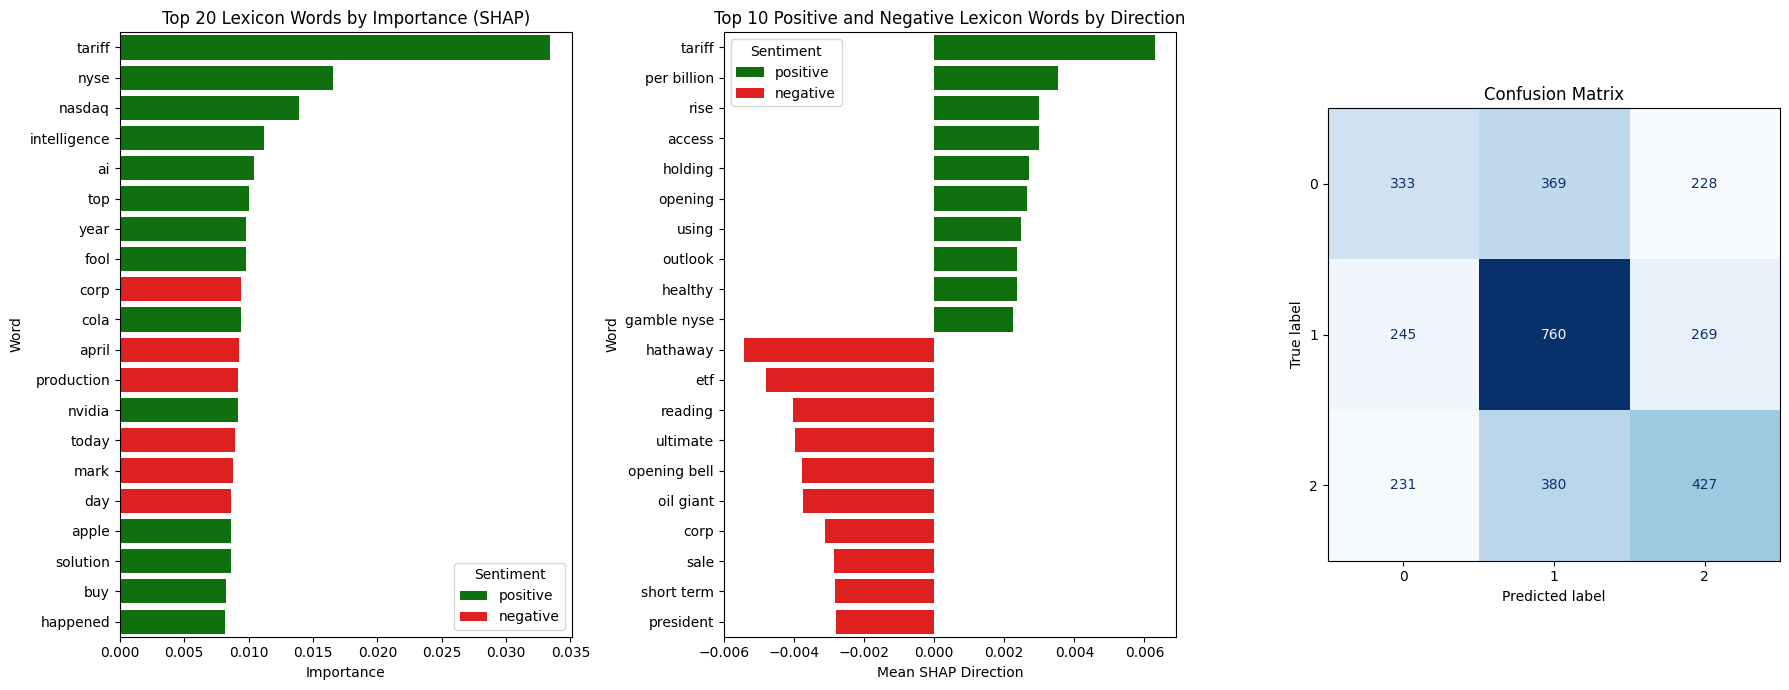

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
top20 = lexicon.head(20)
top_pos = lexicon[lexicon["sentiment"] == "positive"].sort_values("direction", ascending=False).head(10)
top_neg = lexicon[lexicon["sentiment"] == "negative"].sort_values("direction").head(10)
top_dir = pd.concat([top_pos, top_neg])

# Create figure with 2 axes
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Plot 1: Top 20 by importance
sns.barplot(
    data=top20,
    x="importance",
    y="word",
    hue="sentiment",
    dodge=False,
    palette={"positive": "green", "negative": "red"},
    ax=axes[0]
)
axes[0].set_title("Top 20 Lexicon Words by Importance (SHAP)")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Word")
axes[0].legend(title="Sentiment")

# Plot 2: Top 10 positive and negative by direction
sns.barplot(
    data=top_dir,
    x="direction",
    y="word",
    hue="sentiment",
    dodge=False,
    palette={"positive": "green", "negative": "red"},
    ax=axes[1]
)
axes[1].set_title("Top 10 Positive and Negative Lexicon Words by Direction")
axes[1].set_xlabel("Mean SHAP Direction")
axes[1].set_ylabel("Word")
axes[1].legend(title="Sentiment")

cm = confusion_matrix(y_test, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[2], cmap='Blues', colorbar=False)
axes[2].set_title(f"Confusion Matrix")


plt.tight_layout()
plt.show()

In [ ]:
import shap
import pandas as pd
import numpy as np

# Assume model is trained and X_train is your feature matrix (not a DataFrame)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)  # shap_values.values shape: (n_samples, n_features, n_classes)

# Get feature names
feature_names = sentiment_model.vectorizer.get_feature_names_out()

# Compute mean SHAP values per class
# Result: DataFrame with shape (n_features, n_classes)
mean_shap_per_class = pd.DataFrame(
    shap_values.values.mean(axis=0),  # shape: (n_features, n_classes)
    index=feature_names,
    columns=[f"class_{sentiment_model.label_encoder.classes_[i]}" for i in range(shap_values.values.shape[2])]
)

# Optional: Melt to long format if you want one row per feature-class pair
shap_long = mean_shap_per_class.reset_index().melt(id_vars="index", var_name="class", value_name="mean_direction")
shap_long.rename(columns={"index": "feature"}, inplace=True)

# View result
print(shap_long.head())


In [ ]:
import shap
import pandas as pd
import numpy as np

def build_shap_lexicon(model, X_train, sentiment_class, threshold=0.000):
    """
    Build a SHAP-based sentiment lexicon for a multi-class classifier.
    
    Parameters:
    - model: trained model with SHAP support
    - X_train: training data (array or sparse matrix)
    - vectorizer: fitted vectorizer with get_feature_names_out()
    - class_labels: optional list of class labels (e.g., ['negative', 'neutral', 'positive'])
    - threshold: minimum importance value to include a feature in the output
    
    Returns:
    - lexicon_df: DataFrame with SHAP values per class, importance, and most influential class
    """
    # Compute SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)

    # Extract feature names
    feature_names = sentiment_class.vectorizer.get_feature_names_out()
    class_labels = sentiment_class.label_encoder.classes_
    # Handle class labels

    # Calculate mean SHAP values for each feature per class
    mean_shap = shap_values.values.mean(axis=0)  # shape: (n_features, n_classes)
    abs_mean_shap = np.abs(mean_shap)
    importance = abs_mean_shap.sum(axis=1)
    most_influential_class = abs_mean_shap.argmax(axis=1)
    most_corrolated_class = mean_shap.argmax(axis=1)

    most_influential_class_labels = [class_labels[i] for i in most_influential_class]
    most_corrolated_class_labels = [class_labels[i] for i in most_corrolated_class]

    # Create DataFrame
    lexicon_df = pd.DataFrame(mean_shap, columns=class_labels)
    lexicon_df.insert(0, 'feature', feature_names)
    lexicon_df['importance'] = importance
    lexicon_df['most_influential_class'] = most_influential_class_labels
    lexicon_df['most_corrolated_class'] = most_corrolated_class_labels

    # Filter based on threshold
    lexicon_df = lexicon_df[lexicon_df['importance'] == threshold]

    return lexicon_df


In [95]:
lexicon = build_shap_lexicon(model, X_train, sentiment_model)


100%|===================| 38852/38904 [09:54<00:00]        

In [65]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

100%|===================| 38891/38904 [09:36<00:00]        

In [93]:
np.abs(shap_values.values.mean(axis=0)).sum(axis=1)  # (n_features,)

array([0.00119295, 0.00095643, 0.00028921, ..., 0.00048079, 0.00038172,
       0.        ], shape=(5000,))

In [86]:
(shap_values.values.mean(axis=0)[1]).argmax()

np.int64(0)

In [87]:
np.abs(shap_values.values.mean(axis=0)[1]).argmax()  # Get index of max absolute value for first class

np.int64(2)

In [66]:
mean_shap_abs = np.abs(shap_values.values).mean(axis=(0, 2))
mean_shap = (shap_values.values).mean(axis=(0, 2))

In [106]:
lexicon.sort_values(by='importance', ascending=False, inplace=True)

In [119]:
lexicon

,feature,negative,neutral,positive,importance,most_influential_class,most_corrolated_class
4387,tariff,-0.006095,0.025160,-0.000128,0.031383,neutral,neutral
1490,etf,0.000609,-0.016533,0.001542,0.018685,neutral,positive
1738,fool,0.011589,0.000000,-0.006897,0.018486,negative,negative
4137,solution,0.009512,0.000008,-0.007629,0.017149,negative,negative
1996,hathaway,0.000000,0.000000,-0.016254,0.016254,positive,negative
...,...,...,...,...,...,...,...
3764,retail reit,0.000000,-0.000006,0.000000,0.000006,neutral,negative
1864,get free,0.000000,0.000003,0.000000,0.000003,neutral,neutral
662,call image,0.000000,0.000003,0.000000,0.000003,neutral,neutral
2334,ixic,-0.000002,0.000000,0.000000,0.000002,negative,neutral


In [59]:
lexicon.sort_values("negative", ascending=False).head(10)

,feature,negative,neutral,positive,importance,most_influential_class
1738,fool,0.011589,0.000000,-0.006897,0.011589,negative
4137,solution,0.009512,0.000008,-0.007629,0.009512,negative
16,access,0.008952,-0.000009,0.000000,0.008952,negative
2013,healthy,0.007059,0.000009,0.000000,0.007059,negative
3761,retail,0.006996,-0.000645,-0.000791,0.006996,negative
2035,high,0.006453,-0.001817,-0.000983,0.006453,negative
2088,holding,0.005758,-0.000241,0.002603,0.005758,negative
4505,time buy,0.005017,-0.005062,0.000641,0.005062,neutral
4835,way,0.004995,0.000377,-0.000053,0.004995,negative
1384,efficiency,0.004825,-0.002250,0.000000,0.004825,negative


C:\Users\andre\AppData\Local\Temp\ipykernel_9444\3509278598.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\andre\AppData\Local\Temp\ipykernel_9444\3509278598.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\andre\AppData\Local\Temp\ipykernel_9444\3509278598.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\andre\AppData\Local\Temp\ipykernel_9444\3509278598.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` 

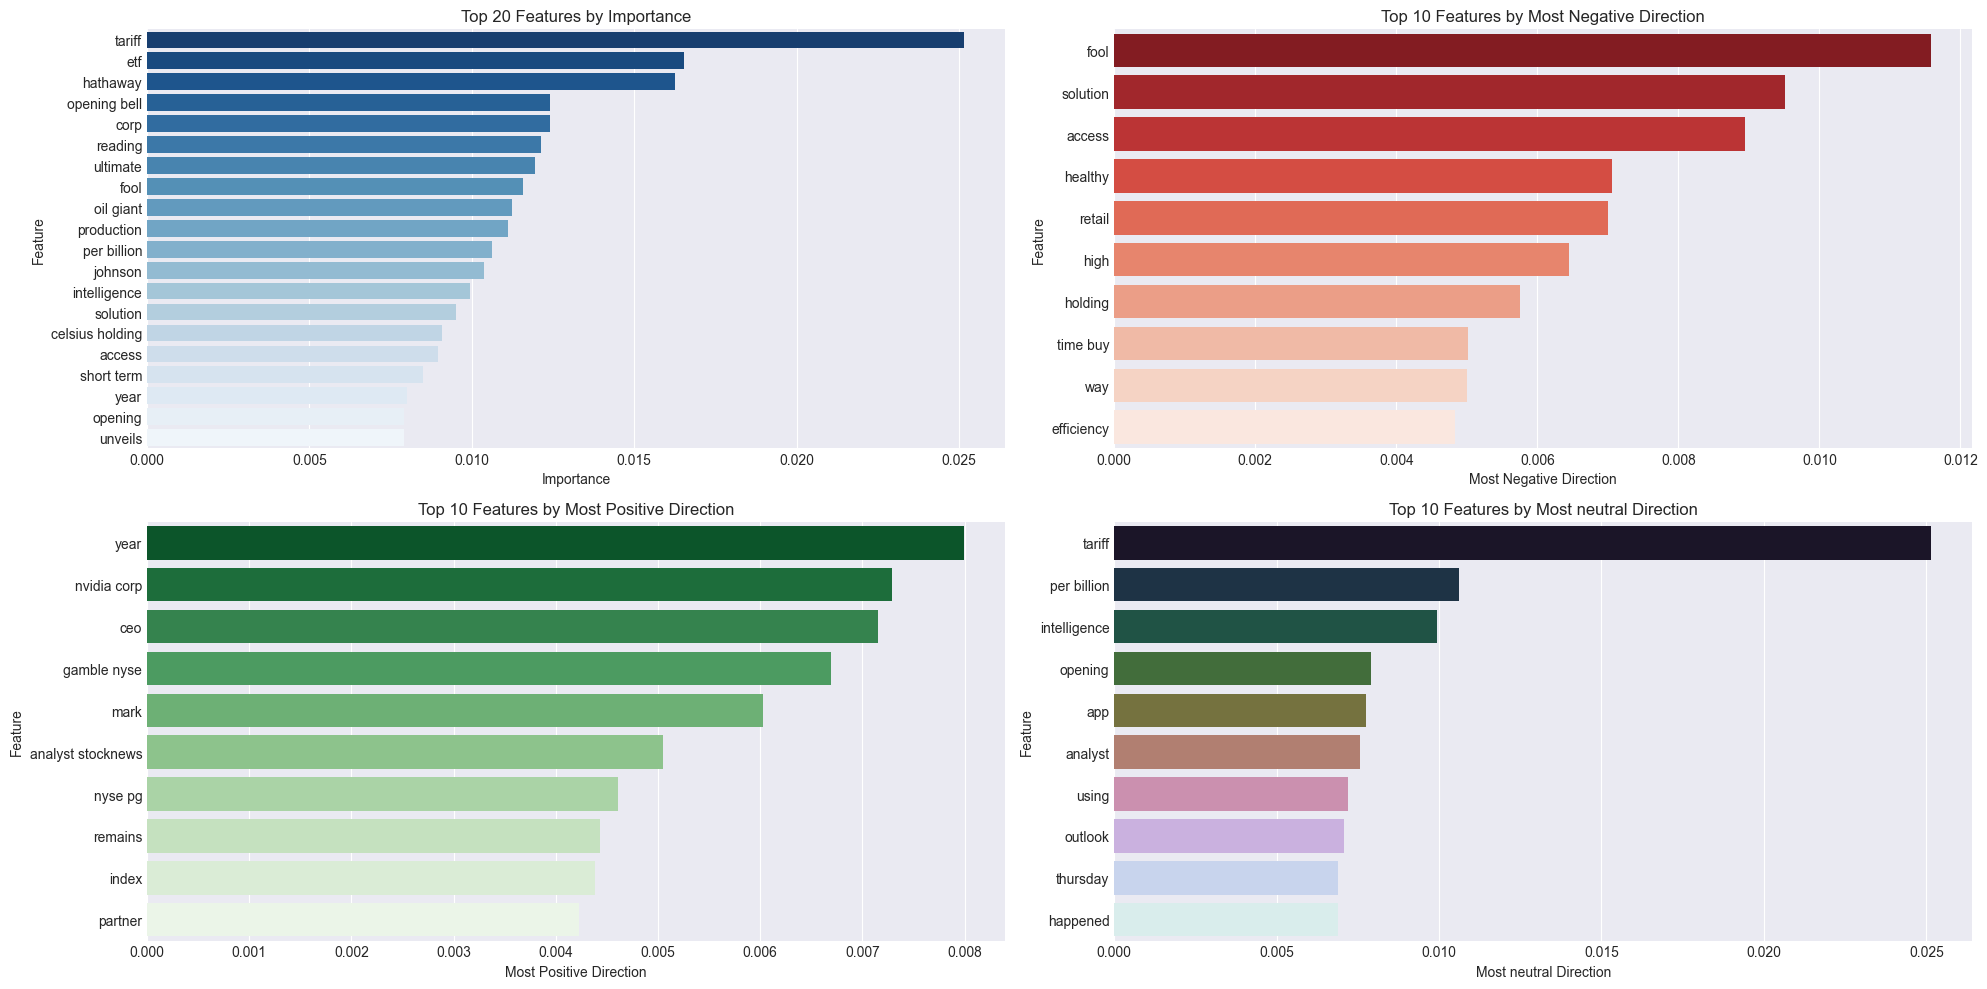

In [49]:
import seaborn as sns

import matplotlib.pyplot as plt

# Top 20 features by importance
top20 = lexicon.sort_values("importance", ascending=False).head(20)

# Top 10 features by most negative direction (across all classes)
top_neg = lexicon.sort_values("negative", ascending=False).head(10)

# Top 10 features by most positive direction (across all classes)
top_pos = lexicon.sort_values("positive", ascending=False).head(10)

top_neutral = lexicon.sort_values("neutral", ascending=False).head(10)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plot 1: Top 20 by importance
sns.barplot(
    data=top20,
    x="importance",
    y="feature",
    palette="Blues_r",
    ax=axes[0,0]
)
axes[0,0].set_title("Top 20 Features by Importance")
axes[0,0].set_xlabel("Importance")
axes[0,0].set_ylabel("Feature")

# Plot 2: Top 10 by most negative direction
sns.barplot(
    data=top_neg,
    x="negative",
    y="feature",
    palette="Reds_r",
    ax=axes[0,1]
)
axes[0,1].set_title("Top 10 Features by Most Negative Direction")
axes[0,1].set_xlabel("Most Negative Direction")
axes[0,1].set_ylabel("Feature")

# Plot 3: Top 10 by most positive direction
sns.barplot(
    data=top_pos,
    x="positive",
    y="feature",
    palette="Greens_r",
    ax=axes[1,0]
)
axes[1,0].set_title("Top 10 Features by Most Positive Direction")
axes[1,0].set_xlabel("Most Positive Direction")
axes[1,0].set_ylabel("Feature")

sns.barplot(
    data=top_neutral,
    x="neutral",
    y="feature",
    palette="cubehelix",
    ax=axes[1,1]
)
axes[1,1].set_title("Top 10 Features by Most neutral Direction")
axes[1,1].set_xlabel("Most neutral Direction")
axes[1,1].set_ylabel("Feature")


plt.tight_layout()
plt.show()

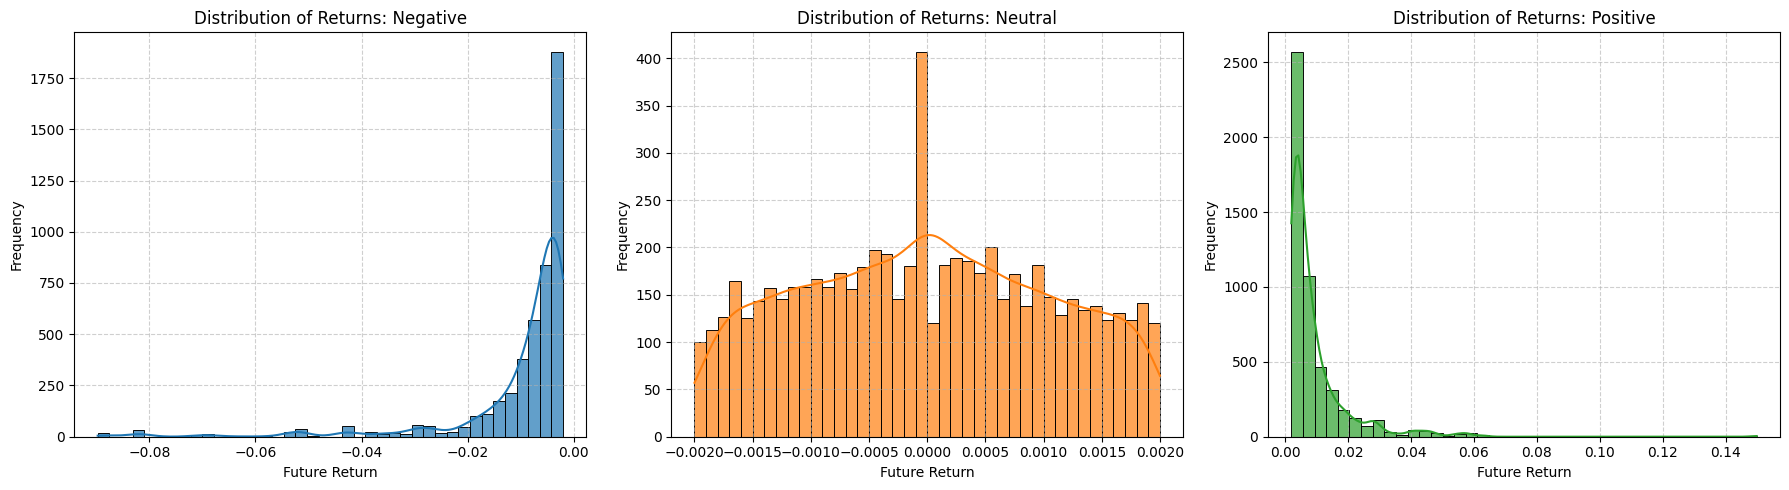

In [21]:
import seaborn as sns

import matplotlib.pyplot as plt

classes = labelencoder.classes_
plt.figure(figsize=(18, 5))
for i, label in enumerate(classes):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[data['sentiment_label'] == label]['future_return'], bins=40, kde=True, color=sns.color_palette()[i], alpha=0.7)
    plt.title(f"Distribution of Returns: {label.capitalize()}")
    plt.xlabel("Future Return")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
def predict_custom_text(sentiment_model, custom_text, model):
    # Clean and preprocess the input using same pipeline
    df = pd.DataFrame({'title': [""], 'summary': [custom_text], 'open_price': [0], 'future_price': [0]})
    
    # Use the same preprocessing (without retraining the vectorizer)
    X_custom = df.copy()
    X_custom['text'] = df['title'] + ' ' + df['summary']
    X_custom['cleaned_text'] = X_custom['text'].apply(sentiment_model.clean_text)  # assuming method is private

    # Transform using existing vectorizer
    X_vect = sentiment_model.vectorizer.transform(X_custom['cleaned_text'])
    temp_df = pd.DataFrame(X_vect.toarray(), columns=sentiment_model.vectorizer.get_feature_names_out())
    # Predict
    prediction = model.predict(temp_df)
    label = sentiment_model.label_encoder.inverse_transform(prediction)[0]
    one_indices = temp_df.columns[temp_df.iloc[0] > 0].tolist()

    # Optionally: show predicted probabilities
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(temp_df)[0]
        class_probs = dict(zip(sentiment_model.label_encoder.classes_, probs))
    else:
        class_probs = None

    return label, class_probs, one_indices


In [ ]:
custom_text = "The stock market is expected to rise due to positive economic indicators."
predicted_label, predicted_probs, features = predict_custom_text(sentiment_model, custom_text, model)
print(f"Custom Text: {custom_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Predicted Probabilities: {predicted_probs}")
print(f"Features contributing to the prediction: {features}")
feature_directions = {word: lexicon.set_index('feature').loc[word, 'most_corrolated_class'] if word in lexicon['feature'].values else None for word in features}
print(f"Feature Directions: {feature_directions}")

Custom Text: The stock market is expected to rise due to positive economic indicators.
Predicted Label: positive
Predicted Probabilities: {'negative': np.float32(0.16726872), 'neutral': np.float32(0.089476734), 'positive': np.float32(0.74325454)}
Features contributing to the prediction: ['due', 'economic', 'expected', 'indicator', 'positive', 'rise']
Feature Directions: {'due': 'positive', 'economic': 'neutral', 'expected': 'positive', 'indicator': 'negative', 'positive': 'negative', 'rise': 'neutral'}


In [122]:
custom_text = "Alien invasion is imminent and nations are preparing for the worst."
predicted_label, predicted_probs, features = predict_custom_text(sentiment_model, custom_text, model)
print(f"Custom Text: {custom_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Predicted Probabilities: {predicted_probs}")
print(f"Features contributing to the prediction: {features}")
feature_directions = {word: lexicon.set_index('feature').loc[word, 'most_corrolated_class'] if word in lexicon['feature'].values else None for word in features}
print(f"Feature Directions: {feature_directions}")


Custom Text: Alien invasion is imminent and nations are preparing for the worst.
Predicted Label: neutral
Predicted Probabilities: {'negative': np.float32(0.18725808), 'neutral': np.float32(0.6196601), 'positive': np.float32(0.19308183)}
Features contributing to the prediction: ['imminent', 'nation', 'preparing', 'worst']
Feature Directions: {'imminent': None, 'nation': 'neutral', 'preparing': 'positive', 'worst': 'neutral'}


In [59]:
lexicon[lexicon['feature'] == "imminent"]

,feature,negative,neutral,positive,importance,most_influential_class


In [18]:
# Find all columns in X_df that contain the word 'tariff'
tariff_cols = [col for col in X_df.columns if 'tariff' in col]

# Sum the occurrences of 'tariff' words for each row
tariff_counts = X_df[tariff_cols].sum(axis=1)

# Add the counts to the data DataFrame
data_with_tariff = data.copy()
data_with_tariff['tariff_count'] = tariff_counts

# Group by future_time (or another time column if you want) and sum the tariff counts
tariff_by_time = data_with_tariff.groupby('future_time')['tariff_count'].sum().sort_values(ascending=False)

# Show the timespans with the most 'tariff' mentions
print(tariff_by_time.head(10))

future_time
2024-04-25 20:00:00    5.672929
2024-04-29 20:00:00    5.147754
2024-04-22 20:00:00    4.636851
2024-04-24 20:00:00    4.080089
2024-04-23 20:00:00    3.674632
2025-04-14 20:00:00    3.280339
2025-04-21 20:00:00    3.070553
2025-04-23 20:00:00    2.862254
2025-04-16 20:00:00    2.569035
2024-04-17 20:00:00    2.441289
Name: tariff_count, dtype: float64


In [44]:
# Drop overlapping columns from X_df before joining
overlap_cols = data.columns.intersection(X_df.columns)
X_df_no_overlap = X_df.drop(columns=overlap_cols, errors='ignore')

# Join X_df to data using the index
data_with_features = data.join(X_df_no_overlap, how='left')
data_with_features.head()

,ticker,url,title,summary,source_domain,closest_time_before_published,future_time,adjusted_future_time,open_price,future_price,...,zacks focus,zacks industry,zacks investment,zacks premium,zacks rank,zacks style,zacks top,zero,zone,zuckerberg
0,AAPL,https://www.marketwatch.com/story/apple-card-s...,Apple Card savings account has an attractive 4...,The tech giant recently debuted a new savings ...,www.marketwatch.com,2023-05-02 18:20:00+00:00,2023-05-02 18:30:00,2023-05-02 18:30:00,168.64,168.600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAPL,https://www.benzinga.com/markets/options/23/05...,Apple Unusual Options Activity For May 02 - Ap...,A whale with a lot of money to spend has taken...,www.benzinga.com,2023-05-02 14:10:00+00:00,2023-05-02 14:20:00,2023-05-02 14:20:00,169.30,168.720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AAPL,https://www.marketwatch.com/story/more-than-90...,More than 90% of Apple's production is still i...,Morgan Stanley has taken a deep-dive look at w...,www.marketwatch.com,2023-05-01 19:50:00+00:00,2023-05-01 20:00:00,2023-05-02 13:30:00,169.48,169.835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAPL,https://www.fool.com/investing/2023/05/02/2-go...,"2 Good Reasons to Buy Apple Stock, and 1 Major...","This incredible growth story is far from over,...",www.fool.com,2023-05-01 19:50:00+00:00,2023-05-01 20:00:00,2023-05-02 13:30:00,169.48,169.835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAPL,https://www.fool.com/investing/2023/05/02/appl...,Apple Is About to Increase Its Dividend: What ...,"Awash in cash, the tech giant still has its wo...",www.fool.com,2023-05-02 15:40:00+00:00,2023-05-02 15:50:00,2023-05-02 15:50:00,167.85,167.620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_with_features["tariff"]

np.float64(96.04413739510233)

In [54]:
tariff_dates = data_with_features.loc[data_with_features["tariff"] > 0, "future_time"]
print(tariff_dates)

791      2024-04-15 14:30:00
800      2024-04-29 15:00:00
801      2024-04-15 20:00:00
803      2024-03-27 20:00:00
806      2024-04-29 14:30:00
                ...         
15325    2025-03-21 19:00:00
15338    2025-04-23 13:40:00
15378    2025-04-10 19:40:00
15388    2025-03-17 14:40:00
15447    2025-04-28 17:40:00
Name: future_time, Length: 583, dtype: object


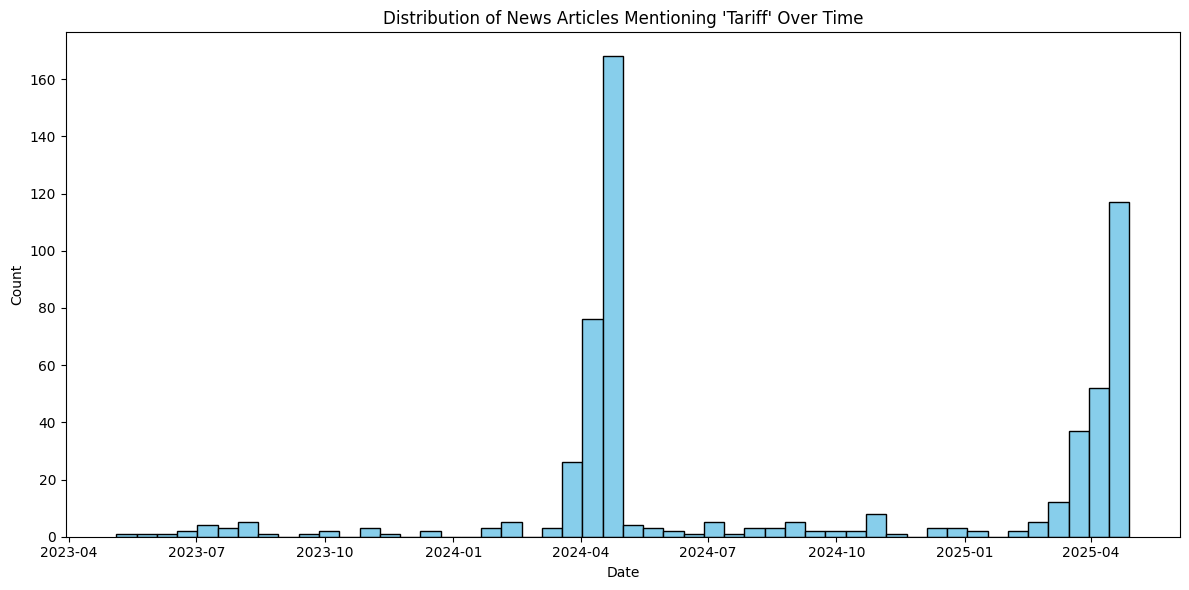

In [55]:
import pandas as pd

import matplotlib.pyplot as plt

# Convert tariff_dates to datetime if not already
tariff_dates_dt = pd.to_datetime(tariff_dates)

plt.figure(figsize=(12, 6))
plt.hist(tariff_dates_dt, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of News Articles Mentioning 'Tariff' Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [56]:
# Get rows where tariff_count > 0
tariff_positive = data_with_tariff[data_with_tariff["tariff_count"] > 0]

# Calculate price return in percent for those rows
tariff_positive["price_return_pct"] = 100 * (tariff_positive["future_price"] - tariff_positive["open_price"]) / tariff_positive["open_price"]

# Show the result
tariff_positive[["ticker", "future_time", "open_price", "future_price", "price_return_pct"]].head()

C:\Users\andre\AppData\Local\Temp\ipykernel_2092\1149852684.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tariff_positive["price_return_pct"] = 100 * (tariff_positive["future_price"] - tariff_positive["open_price"]) / tariff_positive["open_price"]


,ticker,future_time,open_price,future_price,price_return_pct
791,AAPL,2024-04-15 14:30:00,174.83,174.710,-0.068638
800,AAPL,2024-04-29 15:00:00,174.79,174.775,-0.008582
801,AAPL,2024-04-15 20:00:00,173.50,172.465,-0.596542
803,AAPL,2024-03-27 20:00:00,173.34,170.980,-1.361486
806,AAPL,2024-04-29 14:30:00,174.92,174.520,-0.228676


In [57]:
tariff_df = data_with_features[data_with_features["tariff"] > 0]

In [66]:
data_with_features[data_with_features["tariff"] > 0].head(1)

,ticker,url,title,summary,source_domain,closest_time_before_published,future_time,adjusted_future_time,open_price,future_price,...,zacks focus,zacks industry,zacks investment,zacks premium,zacks rank,zacks style,zacks top,zero,zone,zuckerberg
791,AAPL,https://www.benzinga.com/markets/24/04/3824972...,"Market Clubhouse Morning Memo - April 15th, 20...",Good Morning Traders! In today's Market Clubho...,www.benzinga.com,2024-04-15 14:20:00+00:00,2024-04-15 14:30:00,2024-04-15 14:30:00,174.83,174.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
data_with_features[["ticker", "cleaned_text","future_time", "open_price", "future_price", "tariff"]][data_with_features[["ticker", "cleaned_text","future_time", "open_price", "future_price", "tariff"]]["tariff"] > 0].head(1)

,ticker,cleaned_text,future_time,open_price,future_price,tariff
791,AAPL,clubhouse morning memo april th trade strategy...,2024-04-15 14:30:00,174.83,174.71,0.147115


In [39]:
temp_data = data.copy()

In [75]:
# Vectorize the cleaned text using the trained vectorizer
X_vect = sentiment_model.vectorizer.transform(temp_data["cleaned_text"])

# Get feature names and find the index of the word "tariff"
feature_names = sentiment_model.vectorizer.get_feature_names_out()

# Check if "tariff" is in the vocabulary
if "tariff" in feature_names:
    tariff_index = list(feature_names).index("tariff")
    
    # Extract the column for "tariff" and convert to dense array
    tariff_column = X_vect[:, tariff_index].toarray().flatten()
    
    # Add it back to the original DataFrame
    temp_data['tariff_importance'] = tariff_column
    
    # You can now group by date or analyze further
    print(temp_data[['time_published', 'cleaned_text', 'tariff_importance']].sort_values(by='tariff_importance', ascending=False).head(10))
else:
    print("The word 'tariff' was not found in the vectorizer's vocabulary.")


        time_published                                       cleaned_text  \
13656  20250414T145341  tariff amazon kryptonite amazon may take bigge...   
1032   20250407T164500  apple take biggest hit magnificent seven respo...   
2817   20250407T164500  apple take biggest hit magnificent seven respo...   
1393   20250408T221100  reverse direction tariff ante upped china addi...   
3732   20250416T131000  artificial intelligence ai leader nvidia conti...   
18040  20250417T124500  recession chance higher trump tariff dividend ...   
6759   20250411T090208  xi jinping say winner tariff war china slap ta...   
15153  20250313T203000  impact new tariff regime try size impact highe...   
16787  20250313T203000  impact new tariff regime try size impact highe...   
15547  20250401T080500  could benefit new trump tariff much tariff dri...   

       tariff_importance  
13656           0.508468  
1032            0.476910  
2817            0.476910  
1393            0.451857  
3732            0

In [82]:
tariff_df = temp_data[temp_data['tariff_importance'] > 0]

In [86]:
len(tariff_df)

859

In [81]:
X_vect = sentiment_model.vectorizer.transform(temp_data[temp_data['tariff_importance'] > 0].head(1)["cleaned_text"])
temp_df = pd.DataFrame(X_vect.toarray(), columns=sentiment_model.vectorizer.get_feature_names_out())
print(temp_df.columns[temp_df.iloc[0] > 0].tolist())

['aapl', 'apple', 'buy', 'buy sell', 'china', 'competition', 'concern', 'date', 'dip', 'dropped', 'hold', 'sell', 'sell hold', 'stiff', 'stiff competition', 'stretched', 'stretched valuation', 'tariff', 'valuation', 'year', 'year date']


In [95]:
tariff_df['time_published']

1005    2025-04-21
1015    2025-04-08
1016    2025-04-15
1018    2025-04-11
1025    2025-04-04
           ...    
24992   2025-01-22
24999   2025-04-15
25018   2025-04-18
25066   2025-03-25
25125   2025-04-03
Name: time_published, Length: 859, dtype: datetime64[ns]

C:\Users\andre\AppData\Local\Temp\ipykernel_2092\2998591244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tariff_df['time_published'] = pd.to_datetime(tariff_df['time_published'])
C:\Users\andre\AppData\Local\Temp\ipykernel_2092\2998591244.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tariff_df['month_year'] = tariff_df['time_published'].dt.to_period('M').astype(str)


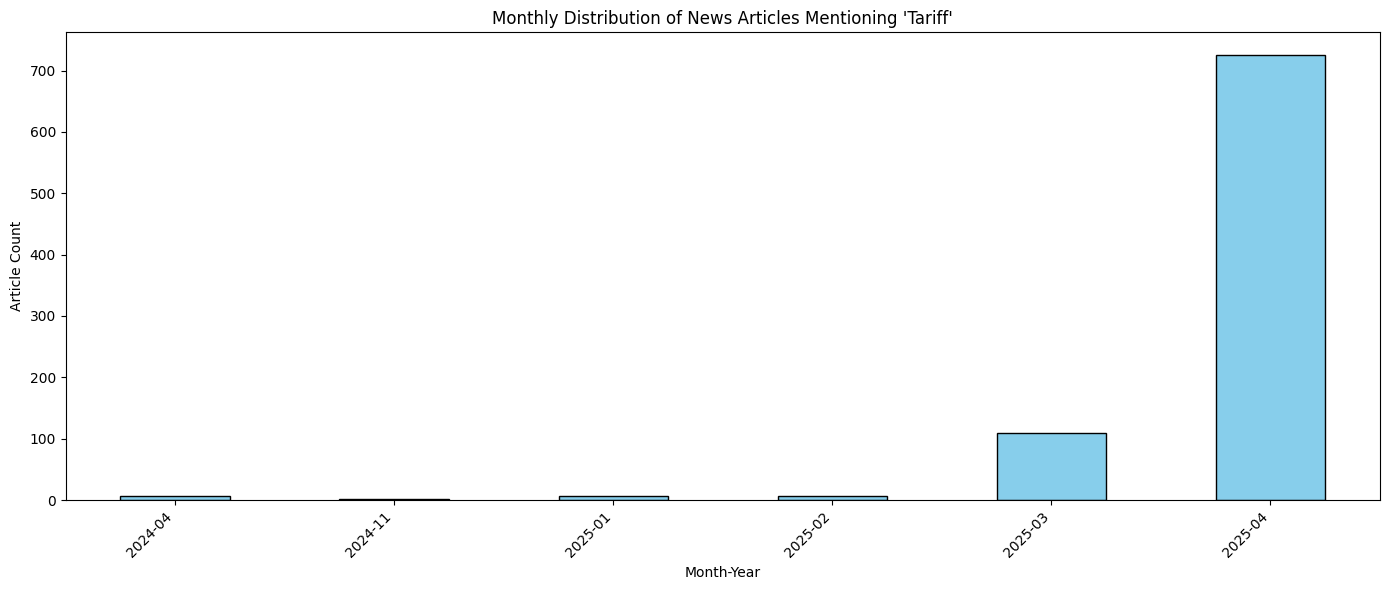

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
tariff_df['time_published'] = pd.to_datetime(tariff_df['time_published'])

# Extract year-month as 'YYYY-MM'
tariff_df['month_year'] = tariff_df['time_published'].dt.to_period('M').astype(str)

# Count occurrences per month
monthly_counts = tariff_df['month_year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(14, 6))
monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Monthly Distribution of News Articles Mentioning 'Tariff'")
plt.xlabel("Month-Year")
plt.ylabel("Article Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\andre\AppData\Local\Temp\ipykernel_2092\2024244833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tariff_df['date_only'] = pd.to_datetime(tariff_df['time_published']).dt.date


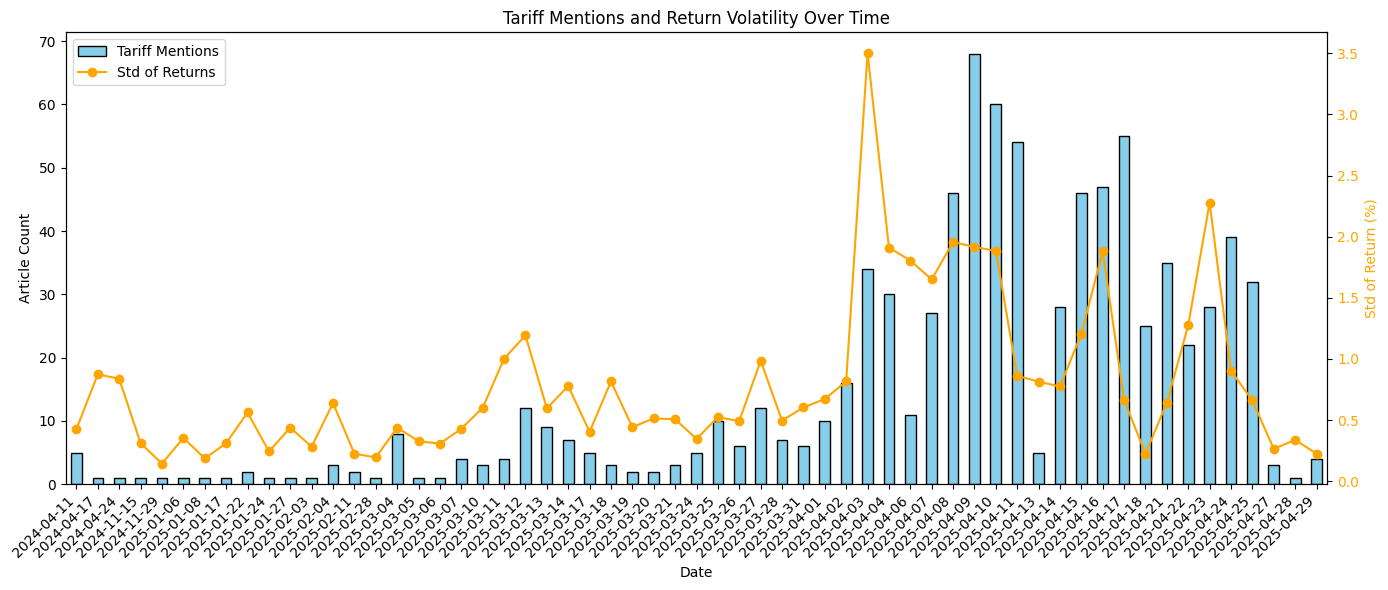

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract date and compute return
tariff_df['date_only'] = pd.to_datetime(tariff_df['time_published']).dt.date
temp_data['date_only'] = pd.to_datetime(temp_data['time_published']).dt.date
temp_data['return_pct'] = 100 * (temp_data['future_price'] - temp_data['open_price']) / temp_data['open_price']

# Count mentions and compute std
tariff_counts = tariff_df['date_only'].value_counts().sort_index()
std_by_date = temp_data.groupby('date_only')['return_pct'].std().reindex(tariff_counts.index)

# Fill NaNs (optional)
std_by_date = std_by_date.fillna(0)

# Plot
plt.figure(figsize=(14, 6))
ax = tariff_counts.plot(kind='bar', color='skyblue', edgecolor='black', label="Tariff Mentions")
plt.title("Tariff Mentions and Return Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Article Count")

# Secondary axis
ax2 = ax.twinx()
ax2.plot(range(len(std_by_date)), std_by_date, color='orange', marker='o', label="Std of Returns")
ax2.set_ylabel("Std of Return (%)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Fix x-axis labels
ax.set_xticks(range(len(tariff_counts)))
ax.set_xticklabels(pd.to_datetime(tariff_counts.index).strftime('%Y-%m-%d'), rotation=45, ha='right')

# Legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\andre\AppData\Local\Temp\ipykernel_2092\3590549483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tariff_df['date_only'] = pd.to_datetime(tariff_df['time_published']).dt.date


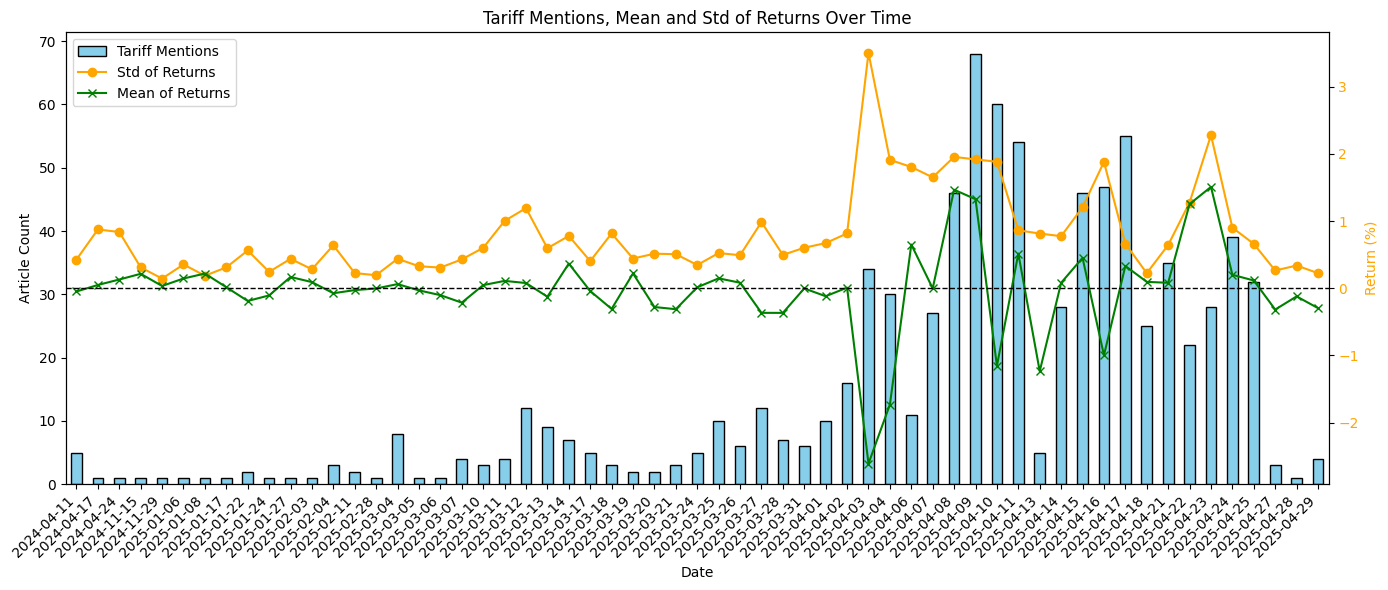

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract date and compute return
tariff_df['date_only'] = pd.to_datetime(tariff_df['time_published']).dt.date
temp_data['date_only'] = pd.to_datetime(temp_data['time_published']).dt.date
temp_data['return_pct'] = 100 * (temp_data['future_price'] - temp_data['open_price']) / temp_data['open_price']

# Count mentions, compute std and mean of returns per date
tariff_counts = tariff_df['date_only'].value_counts().sort_index()
std_by_date = temp_data.groupby('date_only')['return_pct'].std().reindex(tariff_counts.index)
mean_by_date = temp_data.groupby('date_only')['return_pct'].mean().reindex(tariff_counts.index)

# Fill NaNs (optional)
std_by_date = std_by_date.fillna(0)
mean_by_date = mean_by_date.fillna(0)

# Plot
plt.figure(figsize=(14, 6))
ax = tariff_counts.plot(kind='bar', color='skyblue', edgecolor='black', label="Tariff Mentions")
plt.title("Tariff Mentions, Mean and Std of Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Article Count")

# Secondary axis for std and mean
ax2 = ax.twinx()
ax2.plot(range(len(std_by_date)), std_by_date, color='orange', marker='o', label="Std of Returns")
ax2.plot(range(len(mean_by_date)), mean_by_date, color='green', marker='x', label="Mean of Returns")
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel("Return (%)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Fix x-axis labels
ax.set_xticks(range(len(tariff_counts)))
ax.set_xticklabels(pd.to_datetime(tariff_counts.index).strftime('%Y-%m-%d'), rotation=45, ha='right')

# Legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_2092\2542371161.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tariff_df['date_only'] = pd.to_datetime(tariff_df['time_published']).dt.date


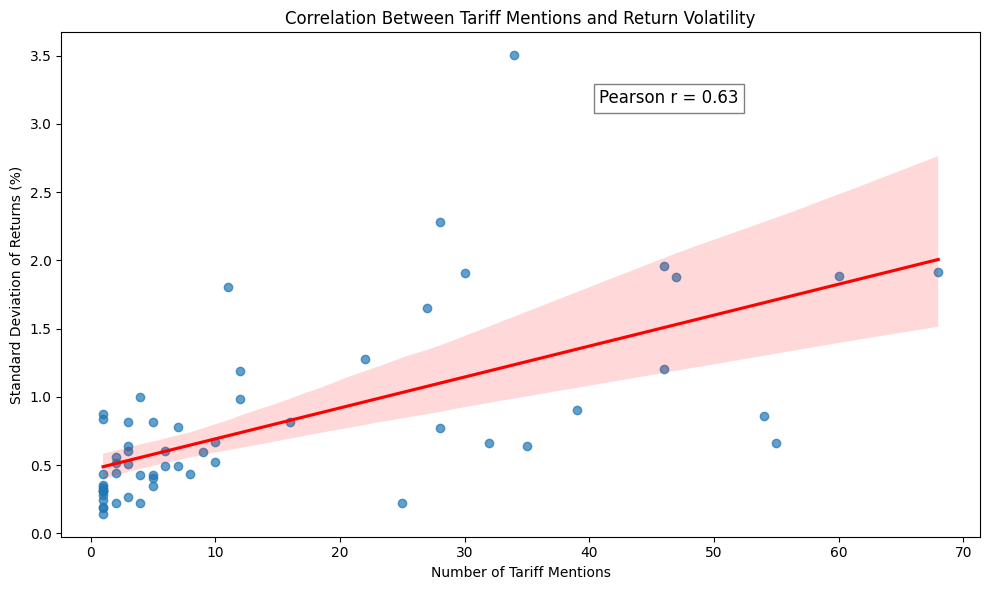

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


tariff_df['date_only'] = pd.to_datetime(tariff_df['time_published']).dt.date
temp_data['date_only'] = pd.to_datetime(temp_data['time_published']).dt.date
temp_data['return_pct'] = 100 * (temp_data['future_price'] - temp_data['open_price']) / temp_data['open_price']

# Count mentions and compute std
tariff_counts = tariff_df['date_only'].value_counts().sort_index()
std_by_date = temp_data.groupby('date_only')['return_pct'].std().reindex(tariff_counts.index)

# Create a DataFrame to correlate
corr_df = pd.DataFrame({
    'tariff_mentions': tariff_counts,
    'return_std': std_by_date
}).dropna()  # Drop dates with NaN std

# Plot correlation
plt.figure(figsize=(10, 6))
sns.regplot(x='tariff_mentions', y='return_std', data=corr_df, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
plt.title('Correlation Between Tariff Mentions and Return Volatility')
plt.xlabel('Number of Tariff Mentions')
plt.ylabel('Standard Deviation of Returns (%)')

# Show Pearson correlation coefficient
corr_coef = corr_df['tariff_mentions'].corr(corr_df['return_std'])
plt.text(x=max(corr_df['tariff_mentions']) * 0.6,
         y=max(corr_df['return_std']) * 0.9,
         s=f'Pearson r = {corr_coef:.2f}',
         fontsize=12,
         bbox=dict(facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()


In [37]:
def plot_feature_mention_and_return_stats(feature_word, data, sentiment_model, temp_data=None):
    """
    Plots the number of articles mentioning a given feature word over time,
    along with the mean and std of returns for those dates.

    Parameters:
    - feature_word: str, the word to search for (e.g., 'tariff')
    - data: DataFrame, must contain 'cleaned_text', 'time_published', 'open_price', 'future_price'
    - sentiment_model: fitted MarketSentiment instance (with vectorizer)
    - temp_data: DataFrame, optional, if you want to use a different DataFrame for return stats
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Use temp_data for returns if provided, else use data
    if temp_data is None:
        temp_data = data.copy()
    else:
        temp_data = temp_data.copy()

    # Vectorize cleaned_text to get feature presence
    X_vect = sentiment_model.vectorizer.transform(data["cleaned_text"])
    feature_names = sentiment_model.vectorizer.get_feature_names_out()

    if feature_word not in feature_names:
        print(f"The word '{feature_word}' was not found in the vectorizer's vocabulary.")
        return

    feature_index = list(feature_names).index(feature_word)
    feature_column = X_vect[:, feature_index].toarray().flatten()
    data_with_feature = data.copy()
    data_with_feature[f'{feature_word}_count'] = feature_column

    # Filter rows where feature is present
    feature_df = data_with_feature[data_with_feature[f'{feature_word}_count'] > 0].copy()
    if feature_df.empty:
        print(f"No articles found mentioning '{feature_word}'.")
        return

    # Extract date and compute return
    feature_df['date_only'] = pd.to_datetime(feature_df['time_published']).dt.date
    temp_data['date_only'] = pd.to_datetime(temp_data['time_published']).dt.date
    temp_data['return_pct'] = 100 * (temp_data['future_price'] - temp_data['open_price']) / temp_data['open_price']

    # Count mentions, compute std and mean of returns per date
    feature_counts = feature_df['date_only'].value_counts().sort_index()
    std_by_date = temp_data.groupby('date_only')['return_pct'].std().reindex(feature_counts.index)
    mean_by_date = temp_data.groupby('date_only')['return_pct'].mean().reindex(feature_counts.index)

    # Fill NaNs (optional)
    std_by_date = std_by_date.fillna(0)
    mean_by_date = mean_by_date.fillna(0)

    # Plot
    plt.figure(figsize=(14, 6))
    ax = feature_counts.plot(kind='bar', color='skyblue', edgecolor='black', label=f"{feature_word.capitalize()} Mentions")
    plt.title(f"{feature_word.capitalize()} Mentions, Mean and Std of Returns Over Time")
    plt.xlabel("Date")
    plt.ylabel("Article Count")

    # Secondary axis for std and mean
    ax2 = ax.twinx()
    ax2.plot(range(len(std_by_date)), std_by_date, color='orange', marker='o', label="Std of Returns")
    ax2.plot(range(len(mean_by_date)), mean_by_date, color='green', marker='x', label="Mean of Returns")
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylabel("Return (%)", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Fix x-axis labels
    ax.set_xticks(range(len(feature_counts)))
    ax.set_xticklabels(pd.to_datetime(feature_counts.index).strftime('%Y-%m-%d'), rotation=45, ha='right')

    # Legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

    # Create a DataFrame to correlate
    corr_df = pd.DataFrame({
        f'{feature_word}_mentions': feature_counts,
        'return_std': std_by_date
    }).dropna()  # Drop dates with NaN std

    # Plot correlation
    plt.figure(figsize=(10, 6))
    sns.regplot(x=f'{feature_word}_mentions', y='return_std', data=corr_df, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
    plt.title(f'Correlation Between {feature_word} Mentions and Return Volatility')
    plt.xlabel(f'Number of {feature_word} Mentions')
    plt.ylabel('Standard Deviation of Returns (%)')

    # Show Pearson correlation coefficient
    corr_coef = corr_df[f'{feature_word}_mentions'].corr(corr_df['return_std'])
    plt.text(x=max(corr_df[f'{feature_word}_mentions']) * 0.6,
            y=max(corr_df['return_std']) * 0.9,
            s=f'Pearson r = {corr_coef:.2f}',
            fontsize=12,
            bbox=dict(facecolor='white', edgecolor='gray'))

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_feature_mention_and_return_stats('tariff', data, sentiment_model, temp_data)

In [40]:
temp_data = data.copy()

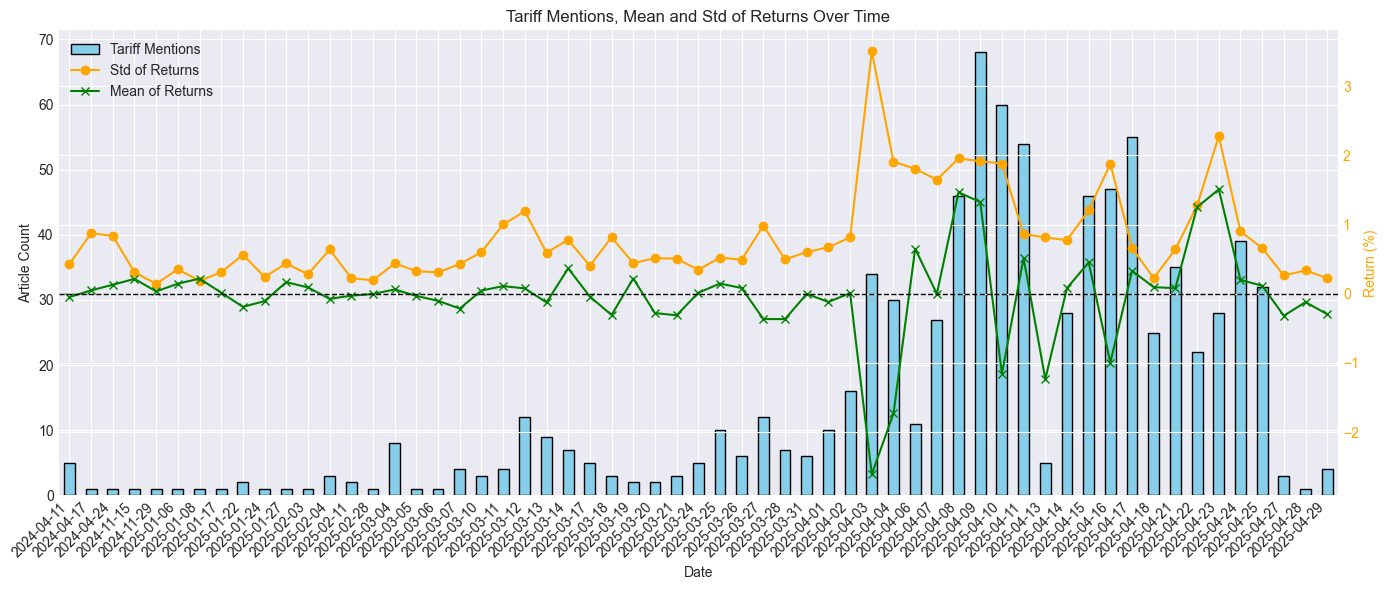

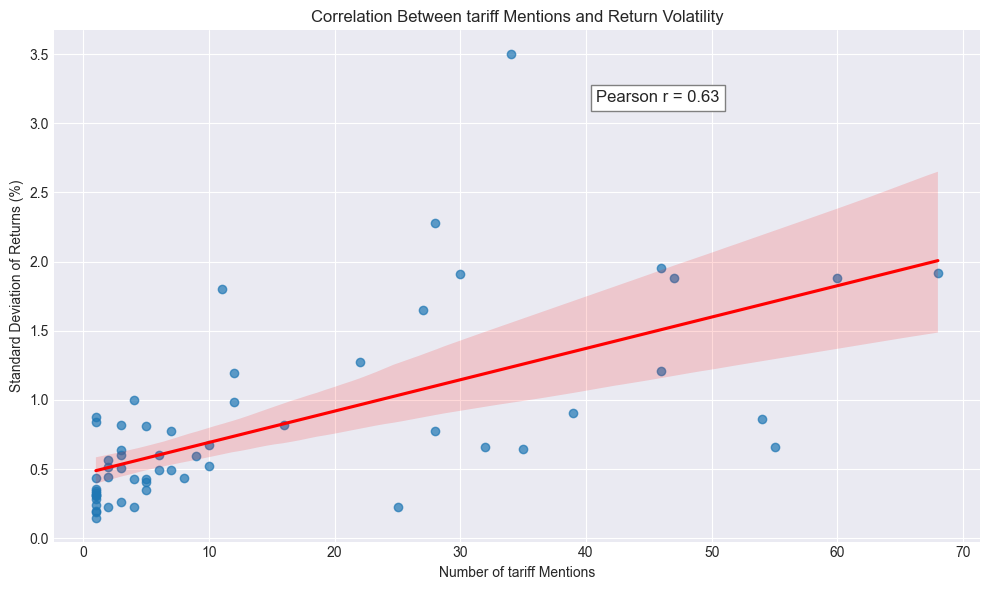

In [41]:
plot_feature_mention_and_return_stats('tariff', data, sentiment_model, temp_data)

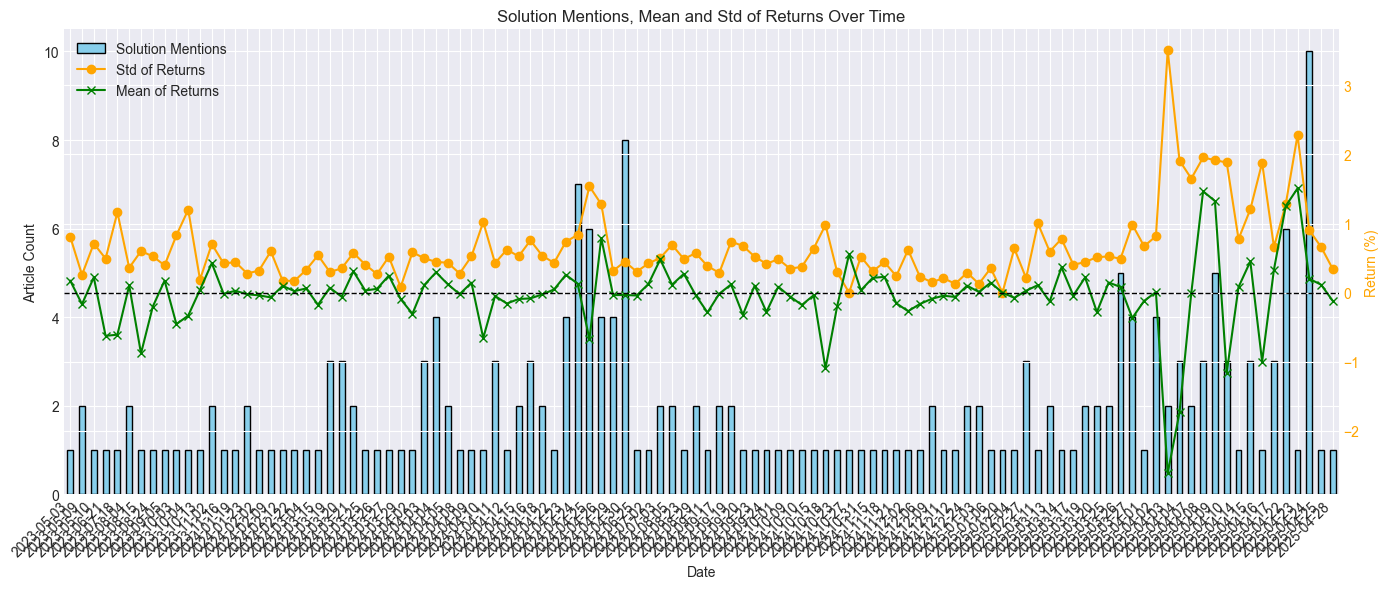

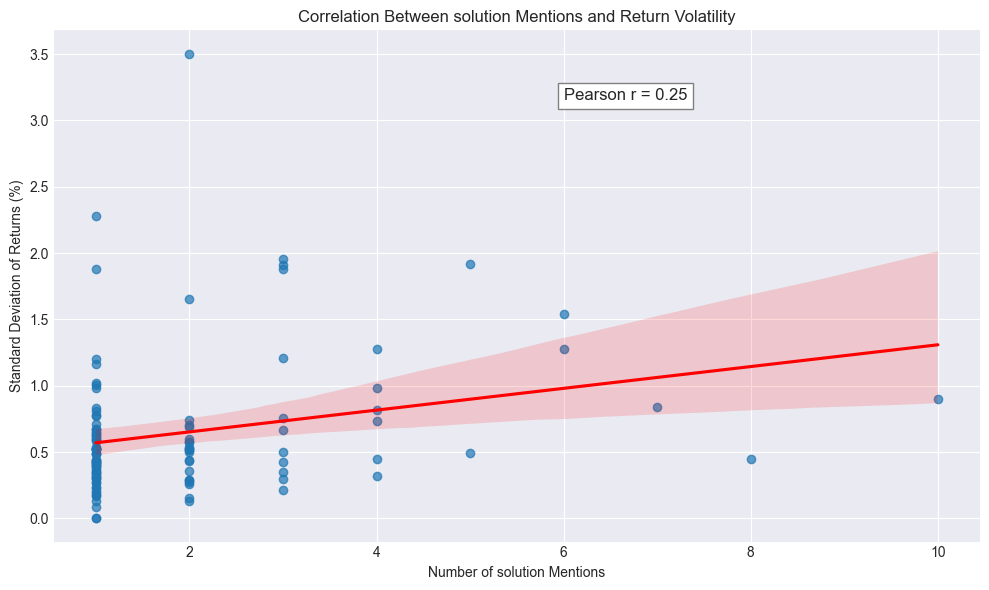

In [47]:
plot_feature_mention_and_return_stats('solution', data, sentiment_model, temp_data)

In [ ]:
lexicon.sort_values("negative", ascending=False).head(10)

,feature,negative,neutral,positive,importance,most_influential_class
1738,fool,0.011589,0.000000,-0.006897,0.011589,negative
4137,solution,0.009512,0.000008,-0.007629,0.009512,negative
16,access,0.008952,-0.000009,0.000000,0.008952,negative
2013,healthy,0.007059,0.000009,0.000000,0.007059,negative
3761,retail,0.006996,-0.000645,-0.000791,0.006996,negative
2035,high,0.006453,-0.001817,-0.000983,0.006453,negative
2088,holding,0.005758,-0.000241,0.002603,0.005758,negative
4505,time buy,0.005017,-0.005062,0.000641,0.005062,neutral
4835,way,0.004995,0.000377,-0.000053,0.004995,negative
1384,efficiency,0.004825,-0.002250,0.000000,0.004825,negative


In [32]:
import pandas as pd

# Load best XGBoost parameters from CSV
best_params_df = pd.read_csv("best_xgb_params_new.csv")
best_params = best_params_df.iloc[0].to_dict()
# Ensure integer parameters are cast correctly
if 'n_estimators' in best_params:
    best_params['n_estimators'] = int(best_params['n_estimators'])
if 'max_depth' in best_params:
    best_params['max_depth'] = int(best_params['max_depth'])

print(best_params)

{'colsample_bynode': 0.6988940467829937, 'learning_rate': 0.2588779055271398, 'max_depth': 9, 'n_estimators': 227, 'subsample': 0.7978944109155615}


In [33]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import numpy as np

# Split data into two periods: 2023-2024 and 2024-2025
complete_df = get_complete_df(tickers, '+10 minutes')
# Ensure time_published is datetime
complete_df['time_published'] = pd.to_datetime(complete_df['time_published'], errors='coerce')

# Define date ranges
period1_mask = (complete_df['time_published'] >= '2023-01-01') & (complete_df['time_published'] < '2024-01-01')
period2_mask = (complete_df['time_published'] >= '2024-01-01') & (complete_df['time_published'] < '2025-01-01')

df1 = complete_df[period1_mask].copy()
df2 = complete_df[period2_mask].copy()

# Preprocess for each period
sentiment_model1 = MarketSentiment(use_lemmatization=True)
X_df1, data1, labelencoder1 = sentiment_model1.preprocess_data(df1, max_features=5000, ngram_range=(1, 2), threshold=0.002)
y1 = data1['encoded_target'].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_df1, y1, test_size=0.2, random_state=42)

sentiment_model2 = MarketSentiment(use_lemmatization=True)
X_df2, data2, labelencoder2 = sentiment_model2.preprocess_data(df2, max_features=5000, ngram_range=(1, 2), threshold=0.002)
y2 = data2['encoded_target'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_df2, y2, test_size=0.2, random_state=42)

# Use best_params from previous optimization
model1 = XGBClassifier(
    **best_params,
    tree_method='hist',
    device='cuda',
    verbosity=1,
    eval_metric='mlogloss'
)
model1.fit(X_train1, y_train1)

model2 = XGBClassifier(
    **best_params,
    tree_method='hist',
    device='cuda',
    verbosity=1,
    eval_metric='mlogloss'
)
model2.fit(X_train2, y_train2)

# SHAP for model1
explainer1 = shap.Explainer(model1, X_train1)
shap_values1 = explainer1(X_train1)
mean_shap_abs1 = np.abs(shap_values1.values).mean(axis=(0, 2))
mean_shap1 = shap_values1.values.mean(axis=(0, 2))
feature_names1 = X_df1.columns
lexicon1 = pd.DataFrame({
    'word': feature_names1,
    'importance': mean_shap_abs1,
    'direction': mean_shap1
})
lexicon1['sentiment'] = np.where(lexicon1['direction'] > 0, 'positive', 'negative')
lexicon1 = lexicon1.sort_values('importance', ascending=False).reset_index(drop=True)

# SHAP for model2
explainer2 = shap.Explainer(model2, X_train2)
shap_values2 = explainer2(X_train2)
mean_shap_abs2 = np.abs(shap_values2.values).mean(axis=(0, 2))
mean_shap2 = shap_values2.values.mean(axis=(0, 2))
feature_names2 = X_df2.columns
lexicon2 = pd.DataFrame({
    'word': feature_names2,
    'importance': mean_shap_abs2,
    'direction': mean_shap2
})
lexicon2['sentiment'] = np.where(lexicon2['direction'] > 0, 'positive', 'negative')
lexicon2 = lexicon2.sort_values('importance', ascending=False).reset_index(drop=True)

# Compare top 20 words by importance in each lexicon
print("Top 20 words in 2023-2024 lexicon:")
print(lexicon1.head(20)[['word', 'importance', 'direction', 'sentiment']])

print("\nTop 20 words in 2024-2025 lexicon:")
print(lexicon2.head(20)[['word', 'importance', 'direction', 'sentiment']])

# Optionally, compare overlap
common_words = set(lexicon1.head(50)['word']).intersection(set(lexicon2.head(50)['word']))
print(f"\nCommon top-50 words in both lexicons: {common_words}")

Fetched 1680 rows for ticker: AAPL
Fetched 1371 rows for ticker: MSFT
Fetched 1375 rows for ticker: NVDA
Fetched 0 rows for ticker: JPM
Fetched 1412 rows for ticker: BAC
Fetched 1376 rows for ticker: GS
Fetched 606 rows for ticker: PLD
Fetched 1285 rows for ticker: O
Fetched 811 rows for ticker: SPG
Fetched 2822 rows for ticker: XOM
Fetched 2851 rows for ticker: CVX
Fetched 1908 rows for ticker: SLB
Fetched 1395 rows for ticker: AMZN
Fetched 1395 rows for ticker: WMT
Fetched 1429 rows for ticker: TGT
Fetched 1411 rows for ticker: KO
Fetched 1384 rows for ticker: PG
Fetched 1417 rows for ticker: PEP
Fetched 1343 rows for ticker: JNJ
Fetched 1385 rows for ticker: PFE
Fetched 1437 rows for ticker: NFLX
Fetched 1170 rows for ticker: DIS
Fetched 0 rows for ticker: CMCSA
Final DataFrame columns: Index(['ticker', 'url', 'title', 'summary', 'source_domain',
       'closest_time_before_published', 'future_time', 'adjusted_future_time',
       'open_price', 'future_price', 'time_published'],
   

100%|===================| 21776/21792 [05:25<00:00]        

Top 20 words in 2023-2024 lexicon:
        word  importance  direction sentiment
0       year    0.069675   0.000734  positive
1     future    0.066774   0.010198  positive
2   industry    0.060229   0.002012  positive
3     recent    0.053650  -0.000987  negative
4    million    0.052579  -0.002199  negative
5       gain    0.051911  -0.000525  negative
6        slb    0.049993   0.005694  positive
7     disney    0.046959  -0.001039  negative
8        buy    0.043348   0.000061  positive
9     growth    0.043002   0.006946  positive
10      nyse    0.041248   0.004094  positive
11     apple    0.040899  -0.005333  negative
12    result    0.039510   0.002148  positive
13       new    0.039494  -0.001408  negative
14    nasdaq    0.039144   0.003452  positive
15     since    0.039118   0.001827  positive
16   company    0.037975   0.000626  positive
17    closed    0.037580   0.000046  positive
18      know    0.037415   0.000109  positive
19      walt    0.037372  -0.001279  negative

In [43]:
print("Opti Metric", opti_metric)    
print("original Metric", original_metric)    

Opti Metric Accuracy: 0.464
Precision: 0.455
Recall: 0.464
F1 Score: 0.452
AUC Class 0: 0.602
AUC Class 1: 0.655
AUC Class 2: 0.628
original Metric Accuracy: 0.451
Precision: 0.448
Recall: 0.451
F1 Score: 0.449
AUC Class 0: 0.586
AUC Class 1: 0.637
AUC Class 2: 0.618


In [17]:
best_params

{'colsample_bynode': np.float64(0.7667818425587761),
 'learning_rate': np.float64(0.08804761772291346),
 'max_depth': 13,
 'n_estimators': 200,
 'subsample': np.float64(0.6178994804139122)}

SPlitting into sector wise models

using onlt XGB regressor test model on seperate sectors

In [155]:
labeled_data.head(1)

,ticker,url,title,summary,source_domain,closest_time_before_published,future_time,adjusted_future_time,open_price,future_price,time_published,text,future_return,cleaned_text,sector
0,AAPL,https://www.marketwatch.com/story/apple-card-s...,Apple Card savings account has an attractive 4...,The tech giant recently debuted a new savings ...,www.marketwatch.com,2023-05-02 18:20:00+00:00,2023-05-02 23:20:00,2023-05-03 13:30:00,168.64,170.26,20230502T182500,Apple Card savings account has an attractive 4...,1.62,apple card saving account attractive interest ...,Technology


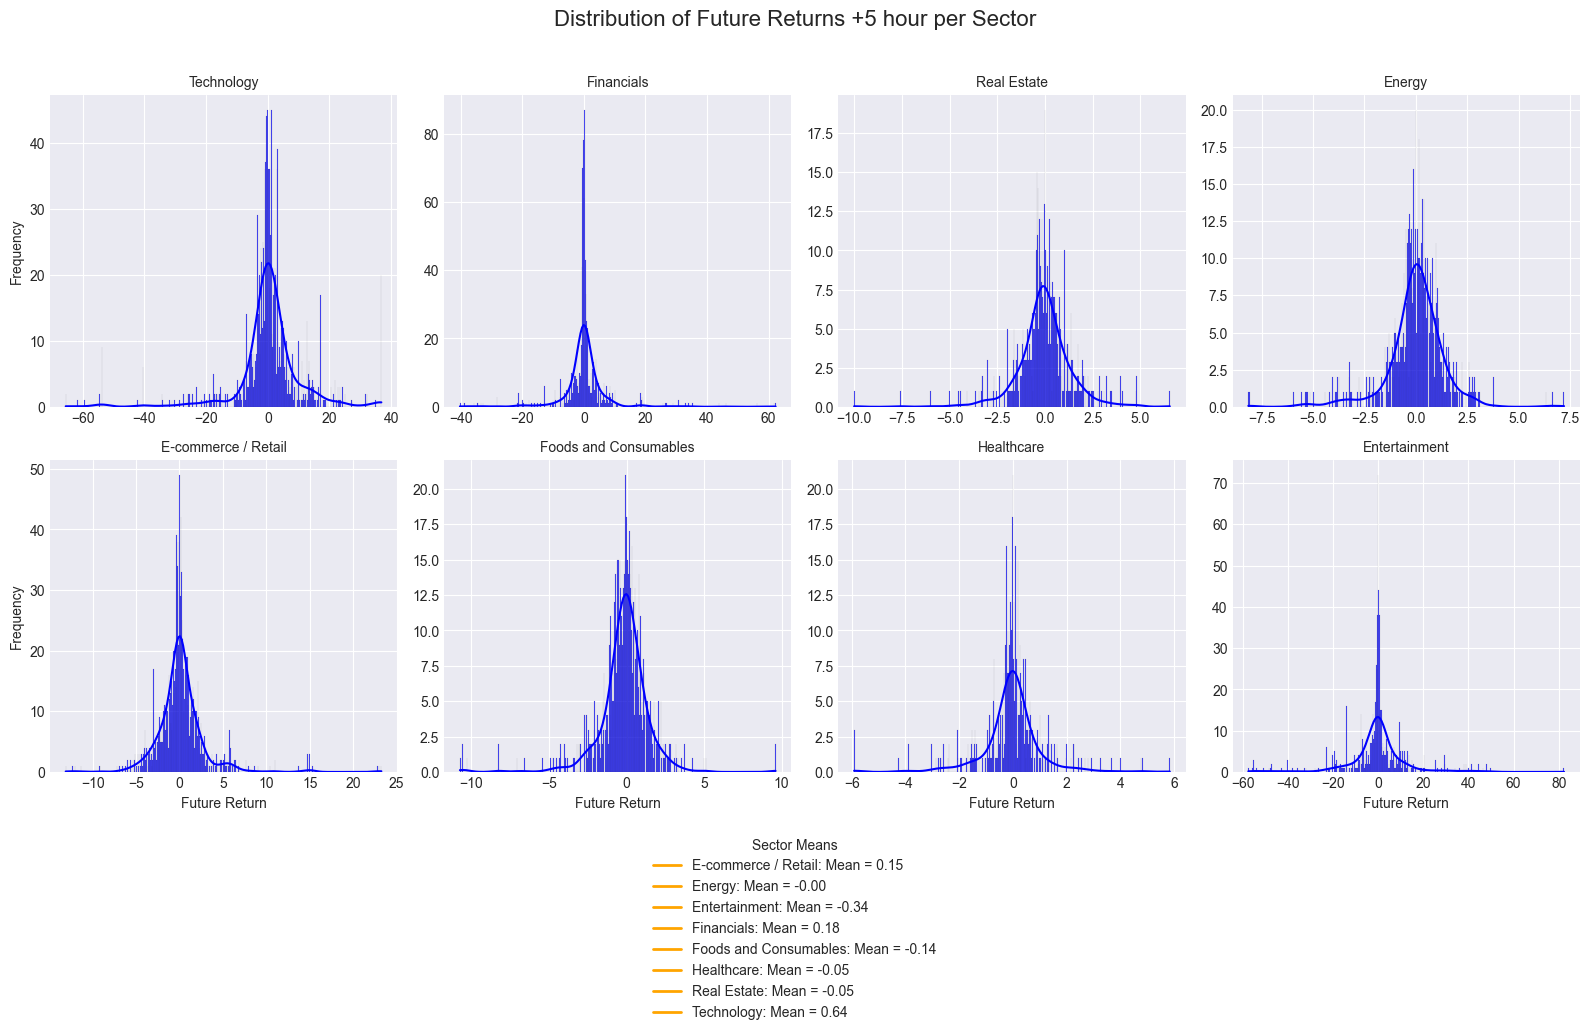

In [156]:
import seaborn as sns

import matplotlib.pyplot as plt

sector_means = labeled_data.groupby('sector')['future_return'].mean()
# Set up the FacetGrid
g = sns.FacetGrid(labeled_data, col="sector", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "future_return", kde=True, bins=500, color="blue", alpha=0.7)

# Add titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Future Return", "Frequency")
g.fig.suptitle("Distribution of Future Returns +5 hour per Sector", fontsize=16, y=1.02)

# Add a custom legend with the mean values
handles = [plt.Line2D([0], [0], color='orange', lw=2, label=f"{sector}: Mean = {mean:.2f}") 
           for sector, mean in sector_means.items()]
g.fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=1, title="Sector Means")


plt.tight_layout()
plt.show()

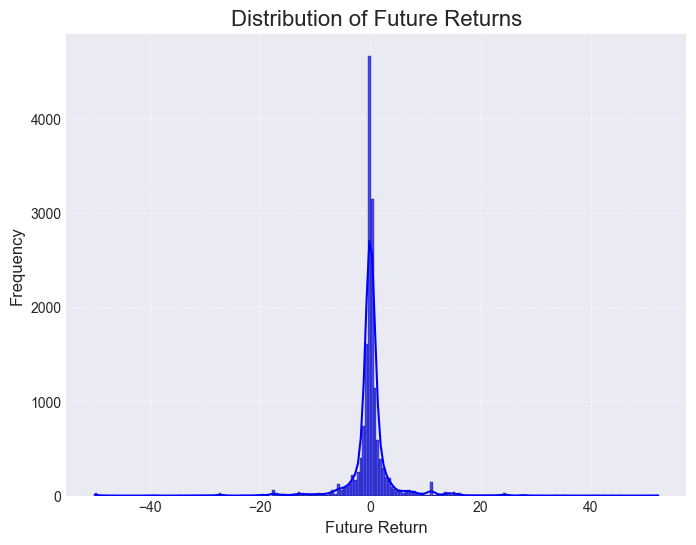

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(labeled_data['future_return'], kde=True, bins=200, color='blue', alpha=0.7)
plt.title('Distribution of Future Returns 1+ hour', fontsize=16)
plt.xlabel('Future Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [143]:
from xgboost import XGBRegressor

sector_results = {}

for sector in sectors:
    print(sector)
    # Filter the data for the current sector
    sector_data = labeled_data[labeled_data['sector'] == sector]
    
    # Check if there are enough samples in the sector
    if len(sector_data) < 10:
        print(f"Not enough data for sector {sector}. Skipping...")
        continue

    # Preprocess the data
    X_df, y_data = sentiment_model.preprocess_data(sector_data)

    # Split the data
    y = y_data[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y, test_size=0.2, random_state=472
    )
    xgbregressor_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',     # or 'gpu_hist' if using GPU
        device='cuda',          # if using GPU
        random_state=42
    )
    xgbregressor_model.fit(X_train, y_train)
    y_pred = xgbregressor_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"XGBoost regressor for {sector} - MSE: {mse:.4f}, R²: {r2:.4f}")
    sector_results[f'XGBoost regressor for {sector}'] = {
        'model': xgbregressor_model,
        'mse': mse,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred,
        'sector': sector,
        'feature_importances': xgbregressor_model.feature_importances_
    }

Technology
Preprocessing data...
Preprocessing text data...
After preprocessing: 3164 articles
XGBoost regressor for Technology - MSE: 31.8768, R²: -0.0693
Financials
Preprocessing data...
Preprocessing text data...
After preprocessing: 2006 articles
XGBoost regressor for Financials - MSE: 43.1351, R²: -0.2101
Real Estate
Preprocessing data...
Preprocessing text data...
After preprocessing: 1236 articles
XGBoost regressor for Real Estate - MSE: 1.3817, R²: -0.4150
Energy
Preprocessing data...
Preprocessing text data...
After preprocessing: 1839 articles
XGBoost regressor for Energy - MSE: 1.1010, R²: -0.0720
E-commerce / Retail
Preprocessing data...
Preprocessing text data...
After preprocessing: 2759 articles
XGBoost regressor for E-commerce / Retail - MSE: 5.2239, R²: -0.3242
Foods and Consumables
Preprocessing data...
Preprocessing text data...
After preprocessing: 2003 articles
XGBoost regressor for Foods and Consumables - MSE: 1.4632, R²: -0.0343
Healthcare
Preprocessing data...
P

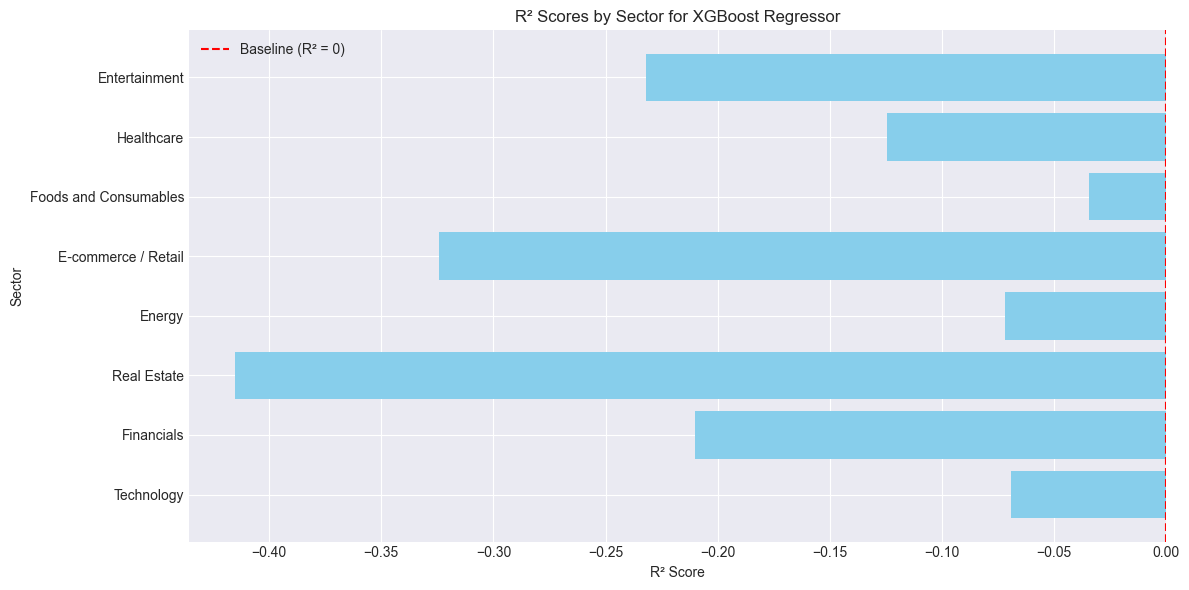

In [144]:
# Extract sector names and R² scores
sector_names = [result['sector'] for result in sector_results.values()]
r2_scores = [result['r2'] for result in sector_results.values()]

# Plot the R² scores for each sector
plt.figure(figsize=(12, 6))
plt.barh(sector_names, r2_scores, color='skyblue')
plt.xlabel('R² Score')
plt.ylabel('Sector')
plt.title('R² Scores by Sector for XGBoost Regressor')
plt.axvline(0, color='red', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.tight_layout()
plt.show()

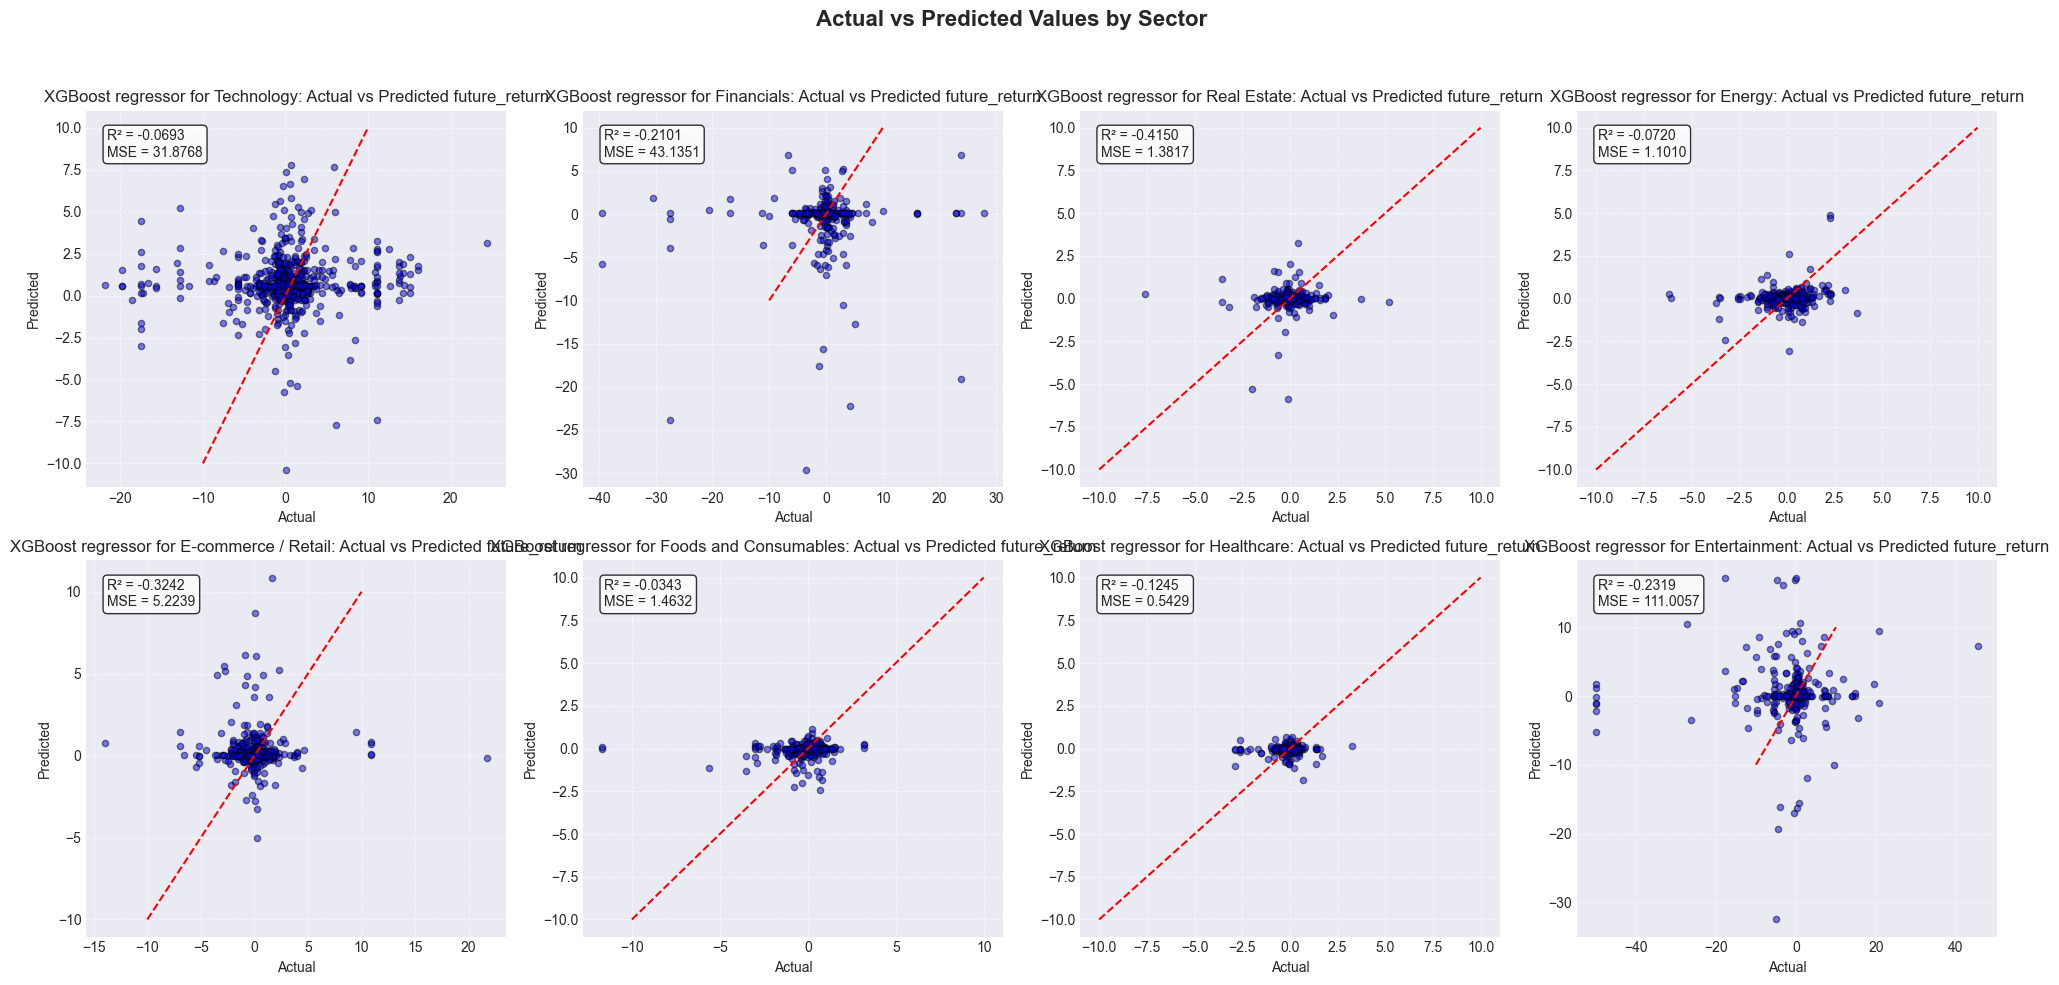

In [145]:
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjusted figure size for better spacing

# Flatten the axes array for easier indexing
axes = axes.flatten()

# 1. Plot actual vs predicted values for each model
for i, (name, result) in enumerate(sector_results.items()):
    ax = axes[i]
    ax.scatter(result['y_test'], result['y_pred'], alpha=0.5, color='blue', edgecolor='k', s=20)
    ax.plot([-10, 10], [-10, 10], 'r--', linewidth=1.5)  # Perfect prediction line
    ax.set_title(f'{name}: Actual vs Predicted {target}', fontsize=12)
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.text(0.05, 0.95, f"R² = {result['r2']:.4f}\nMSE = {result['mse']:.4f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide unused subplots if sector_results has fewer than 8 items
for j in range(len(sector_results), len(axes)):
    fig.delaxes(axes[j])

# Add a main title for the entire figure
fig.suptitle('Actual vs Predicted Values by Sector', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()